In [1]:
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('bmh')
plt.rc('text', usetex=True)
%matplotlib inline
from numba import jit

from time import time


import multiprocessing as mp

from scipy.interpolate import RectBivariateSpline

from ipywidgets import FloatProgress
from IPython.display import display

#from doublegyre import velocity_field

from numerical_integrators.single_step import euler, rk2, rk3, rk4

from numerical_integrators.adaptive_step import rkdp54, rkdp87

In [2]:
def grid_of_particles(Nx, Ny = None, wx = 2, wy = 1):
    if Ny == None:
        Ny = np.round(Nx*wy/wx).astype(int)
        
    dx = wx / Nx
    dy = wy / Ny
    
    x0 = (np.arange(Nx) + 1/2) * dx
    y0 = (np.arange(Ny) + 1/2) * dy
    
    y, x = np.meshgrid(y0, x0)
    
    #pos = np.empty((2, Nx*Ny))
    
    #for j in range(Ny):
    #    pos[0,j*Nx:(j+1)*Nx] = x0
    #    pos[1,j*Nx:(j+1)*Nx] = y0[j]
    
    return np.array([x,y])
    

## Implementation of Eq. (1) in the exam set
#@jit#(nopython=True)
#def doublegyre(t, X, A, e, w):
#    a = e * np.sin(w*t)
#    b = 1 - 2*e*np.sin(w*t)
#    f = a*X[0,:]**2 + b*X[0,:]
#    v = np.empty(X.shape)
#    v[0,:] = -np.pi*A*np.sin(np.pi*f) * np.cos(np.pi*X[1,:])                    # x component of velocity
#    v[1,:] =  np.pi*A*np.cos(np.pi*f) * np.sin(np.pi*X[1,:]) * (2*a*X[0,:] + b) # y component of velocity
#    return v

@jit#(nopython=True)                                                            
def doublegyre(t, x, A, e, w):                                              
    a = e * np.sin(w*t)                                                         
    b = 1 - 2*e*np.sin(w*t)                                                     
    f = a*x[0,:]**2 + b*x[0,:]                                                  
    v = np.empty(np.shape(x))                                                   
    v[0,:] = -np.pi*A*np.sin(np.pi*f)*np.cos(np.pi*x[1,:]) # x-component        
    v[1,:] = np.pi*A*np.cos(np.pi*f)*np.sin(np.pi*x[1,:])*(2*a*x[0,:] + b) # y-component
    return v 
    
# Function wrapper to pass to the integrator.
# x is a two-component vector, x = [x_coord, y_coord]
@jit#(nopython=True)
def vel(t, x):
    # Parameters of the velocity field:
    A = 0.1         # A
    e = 0.1         # epsilon
    w = 2*np.pi/10  # omega
    return doublegyre(t,x,A,e,w)

def endpoints(t_min, t_max, pos_init, stride, integrator, deriv, n_proc = 4):
    
    partition = np.floor(np.size(pos_init, 1) / n_proc).astype(int)
    
    pos = np.empty(np.shape(pos_init))
    
    queuelist = [mp.Queue() for j in range(n_proc)]
    processlist = [mp.Process(target = endpoints_slice, 
                             args = (t_min, t_max,
                                    pos_init[:, j*partition:np.size(pos_init, 1) if j == (n_proc - 1) else (j+1)*partition],
                                    stride, integrator, deriv, queuelist[j])) for j in range(n_proc)]
    
    for process in processlist:
        process.start()
        
    for j, queue in enumerate(queuelist):
        pos[:, j*partition:np.size(pos_init, 1) if j == (n_proc - 1) else (j+1) * partition] = queue.get()
        
    for process in processlist:
        process.join()
    
    return pos
    
def endpoints_slice(t_min, t_max, pos_init_slice, stride, integrator, deriv, q):
    t = np.ones(np.shape(pos_init_slice[0])) * t_min
    h = np.ones(np.shape(pos_init_slice[0])) * stride
    
    pos_slice = np.copy(pos_init_slice)
    
    integration_mask = np.less(t, t_max)
    
    while np.any(integration_mask):
        h[integration_mask] = np.minimum(h[integration_mask], t_max - t[integration_mask])
        t[integration_mask], tmp, h[integration_mask] = integrator(t[integration_mask], pos_slice[:, integration_mask], h[integration_mask], deriv)
        pos_slice[:, integration_mask] = tmp
        integration_mask = np.less(t, t_max)
    
    q.put(pos_slice)

# Step 0: Check that the transport goes as planned

In [3]:
Nx = 400
pos_init = grid_of_particles(Nx)

integrator = rk4

# Transport parameters:
t_min = 0
t_max = 5
h = 0.1

# Loop over grid and update all positions:
tic = time()
pos_fin = endpoints(t_min, t_max, pos_init, h, integrator, vel)
toc = time()

print('Transport took %.3f seconds' % (toc - tic))

Transport took 13.444 seconds


(0, 1)

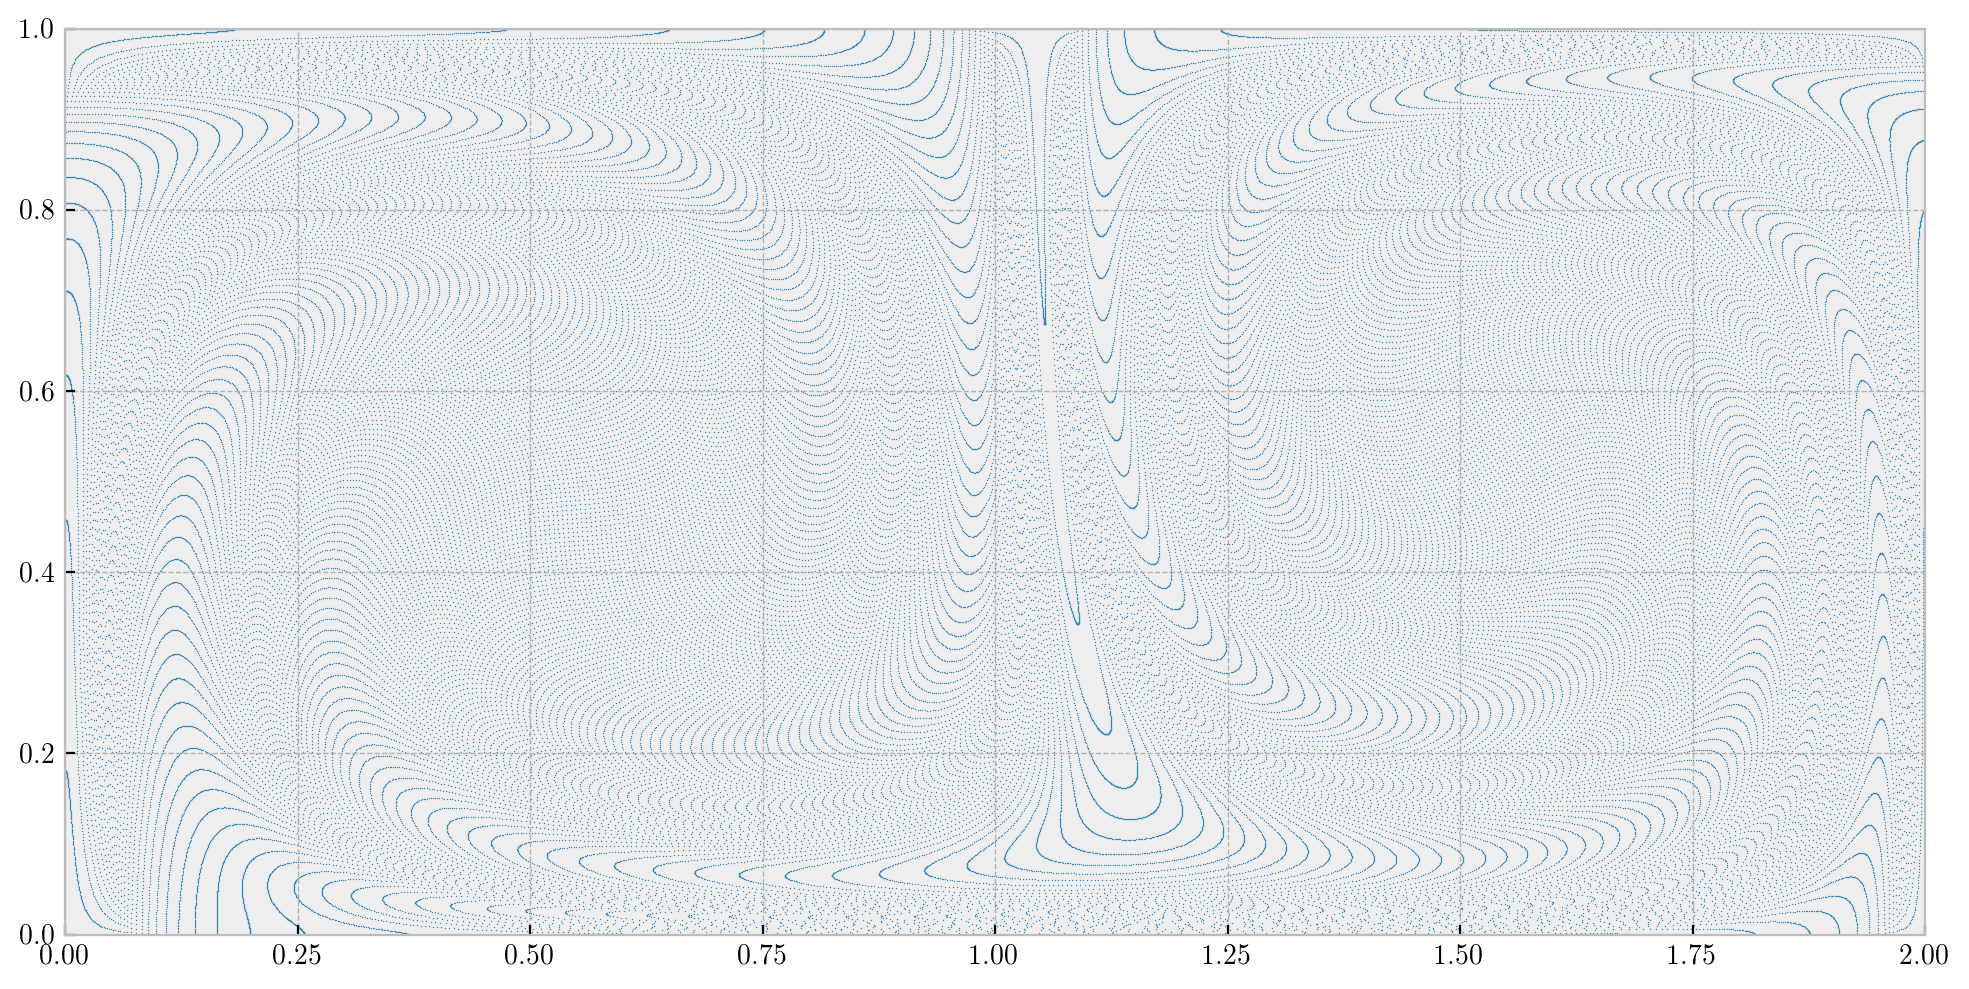

In [4]:
# Make a scatter plot to show grid points:
fig = plt.figure(figsize = (12,6), dpi = 200)
plt.scatter(pos_fin[0,:], pos_fin[1,:], lw = 0, marker = '.', s = 1)
plt.xlim(0, 2)
plt.ylim(0, 1)

# Step 1: Calculate flow map for lots of particles

### In addition, calculate flow map for four auxiliary grid points per particle

In [5]:
# Particle count in the x-direction:
Nx = 1000
# --------''----------- y-direction:
Ny = 500

# ----
#      Main grid:
# ----
pos_init = grid_of_particles(Nx, Ny)

# Grid parameters, original grid:
dx = pos_init[0,-1,0] - pos_init[0, -2,0]
dy = pos_init[1,0,-1] - pos_init[1, 0,-2]

# New transport parameters:
t_min = 0.
t_max = 20.
h = 0.05


# ----
#     Auxiliary grid:
# ----

# Grid spacing: Must be smaller than original grid
d = np.minimum(1e-5, dx * 1e-2)


# ----
#      Integration:
# ----

# Integrator choice:
integrator = rkdp87

# Trajectory endpoints:

tic = time()

pos_fin = endpoints(t_min, t_max, pos_init, h, integrator, vel)


above_fin = endpoints(t_min, t_max, pos_init + np.array([0,d]).reshape(2,1,1), h, integrator, vel)
beneath_fin = endpoints(t_min, t_max, pos_init + np.array([0,-d]).reshape(2,1,1), h, integrator, vel)

right_fin = endpoints(t_min, t_max, pos_init + np.array([d,0]).reshape(2,1,1), h, integrator, vel)
left_fin = endpoints(t_min, t_max, pos_init + np.array([-d,0]).reshape(2,1,1), h, integrator, vel)

toc = time()

print('Transport took %.3f seconds' % (toc - tic))


Transport took 619.829 seconds


# Step 2: Calculate derivatives of flow maps

In [6]:
# [0,0]-component: dx/dx
# [0,1]-component: dx/dy
# [1,0]-component: dy/dx
# [1,1]-component: dy/dy

dF = np.empty((2, 2, Nx, Ny))
dF_a = np.copy(dF)

# Derivatives for auxiliary array:
# Centered differencing throughout
# dx/dx
dF_a[0,0,:,:] = (right_fin[0] - left_fin[0]) / (2*d)
# dx/dy
dF_a[0,1,:,:] = (above_fin[0] - beneath_fin[0]) / (2*d)
# dy/dx
dF_a[1,0,:,:] = (right_fin[1] - left_fin[1]) / (2*d)
# dy/dy
dF_a[1,1,:,:] = (above_fin[1] - beneath_fin[1]) / (2*d)

# Derivatives for main array:

# dx/dx
dF[0,0,0,:]    = (-3*pos_fin[0,0,:] + 4*pos_fin[0,1,:] - 2*pos_fin[0,2,:]) / (2*dx)   # 2nd order accurate forward differencing
dF[0,0,1:-2,:] = (pos_fin[0,2:-1,:] - pos_fin[0,0:-3,:]) / (2*dx)                     # Centered differencing
dF[0,0,-1,:]   = (3*pos_fin[0,-1,:] - 4*pos_fin[0,-2,:] + 2*pos_fin[0,-3,:]) / (2*dx) # 2nd order accurate backward differencing

# dx/dy
dF[0,1,:,0]    = (-3*pos_fin[0,:,0] + 4*pos_fin[0,:,1] - 2*pos_fin[0,:,2]) / (2*dy)   # 2nd order accurate forward differencing
dF[0,1,:,1:-2] = (pos_fin[0,:,2:-1] - pos_fin[0,:,0:-3]) / (2*dy)                     # Centered differencing
dF[0,1,:,-1]   = (3*pos_fin[0,:,-1] - 4*pos_fin[0,:,-2] + 2*pos_fin[0,:,-3]) / (2*dy) # 2nd order accurate backward differencing

# dy/dx
dF[1,0,0,:]    = (-3*pos_fin[1,0,:] + 4*pos_fin[1,1,:] - 2*pos_fin[1,2,:]) / (2*dx)   # 2nd order accurate forward differencing
dF[1,0,1:-2,:] = (pos_fin[1,2:-1,:] - pos_fin[1,0:-3,:]) / (2*dx)                     # Centered differencing
dF[1,0,-1,:]   = (3*pos_fin[1,-1,:] - 4*pos_fin[1,-2,:] + 2*pos_fin[1,-3,:]) / (2*dx) # 2nd order accurate backward differencing

# dy/dy
dF[1,1,:,0]    = (-3*pos_fin[1,:,0] + 4*pos_fin[1,:,1] - 2*pos_fin[1,:,2]) / (2*dy)   # 2nd order accurate forward differencing
dF[1,1,:,1:-2] = (pos_fin[1,:,2:-1] - pos_fin[1,:,0:-3]) / (2*dy)                     # Centered differencing
dF[1,1,:,-1]   = (3*pos_fin[1,:,-1] - 4*pos_fin[1,:,-2] + 2*pos_fin[1,:,-3]) / (2*dy) # 2nd order accurate backward differencing


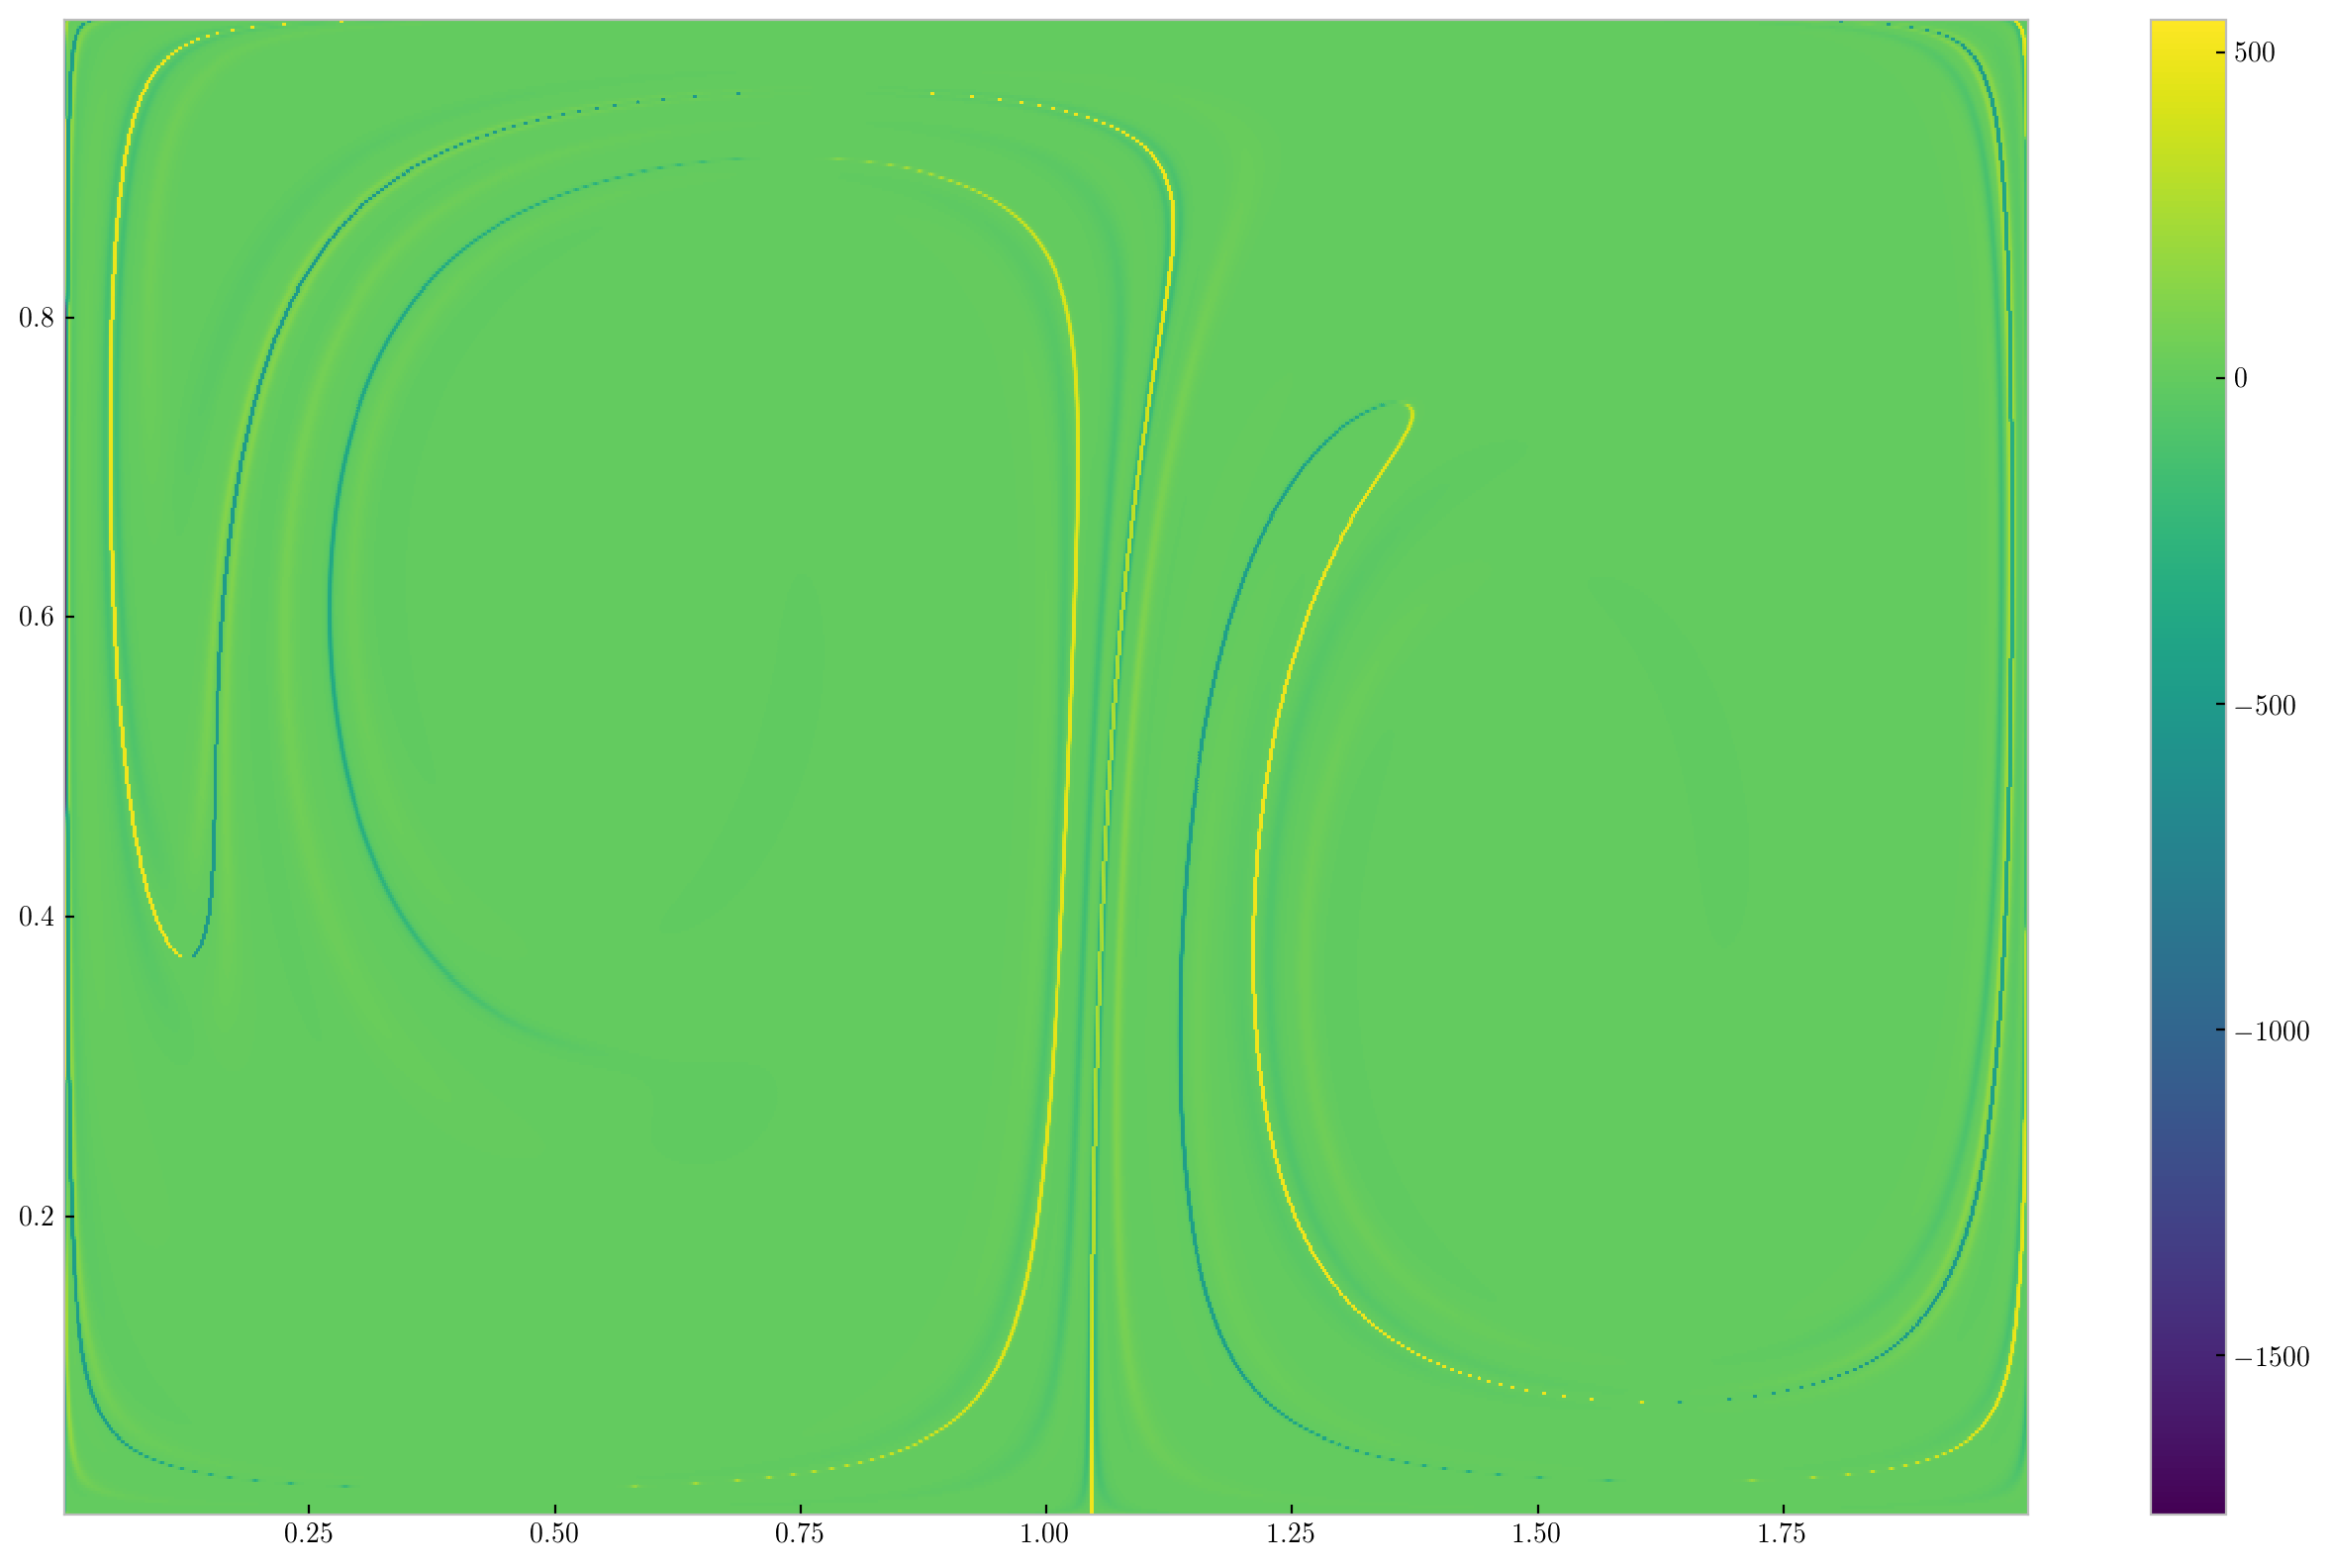

In [7]:
plt.figure(figsize = (16,10), dpi = 200)
mesh = plt.pcolormesh(pos_init[0,:,:], pos_init[1,:,:], dF[0,0,:,:])
plt.colorbar(mesh)


# Step 3: Calculate Cauchy-Green strain tensor

In [8]:
C = np.empty(dF.shape)
C_a = np.empty(dF_a.shape)

assert dF.shape == dF_a.shape

for i in range(dF_a.shape[2]):
    for j in range(dF_a.shape[3]):
        C[:,:,i,j] = np.dot(dF[:,:,i,j].T, dF[:,:,i,j])
        C_a[:,:,i,j] = np.dot(dF_a[:,:,i,j].T, dF_a[:,:,i,j])

# Step 4: Calculate eigenvalues and -vectors of Cauchy-Green strain tensors

In [9]:
evals = np.empty((2, dF_a.shape[2], dF_a.shape[3]))
evecs = np.empty(C.shape)

evals_discard = np.copy(evals)
evecs_discard = np.copy(evecs)

for i in range(dF_a.shape[2]):
    for j in range(dF_a.shape[3]):
        vals, vecs = np.linalg.eigh(C[:,:,i,j])
        vals_a, vecs_a = np.linalg.eigh(C_a[:,:,i,j])
        
        idxvals = vals.argsort()[::-1]
        idxvals_a = vals_a.argsort()[::-1]
        
        evals[:,i,j] = vals[idxvals]
        evecs_discard[:,:,i,j] = vecs[:, idxvals]
        
        evals_discard[:,i,j] = vals_a[idxvals_a] 
        evecs[:,:,i,j] = vecs_a[:,idxvals_a]

(0, 1)

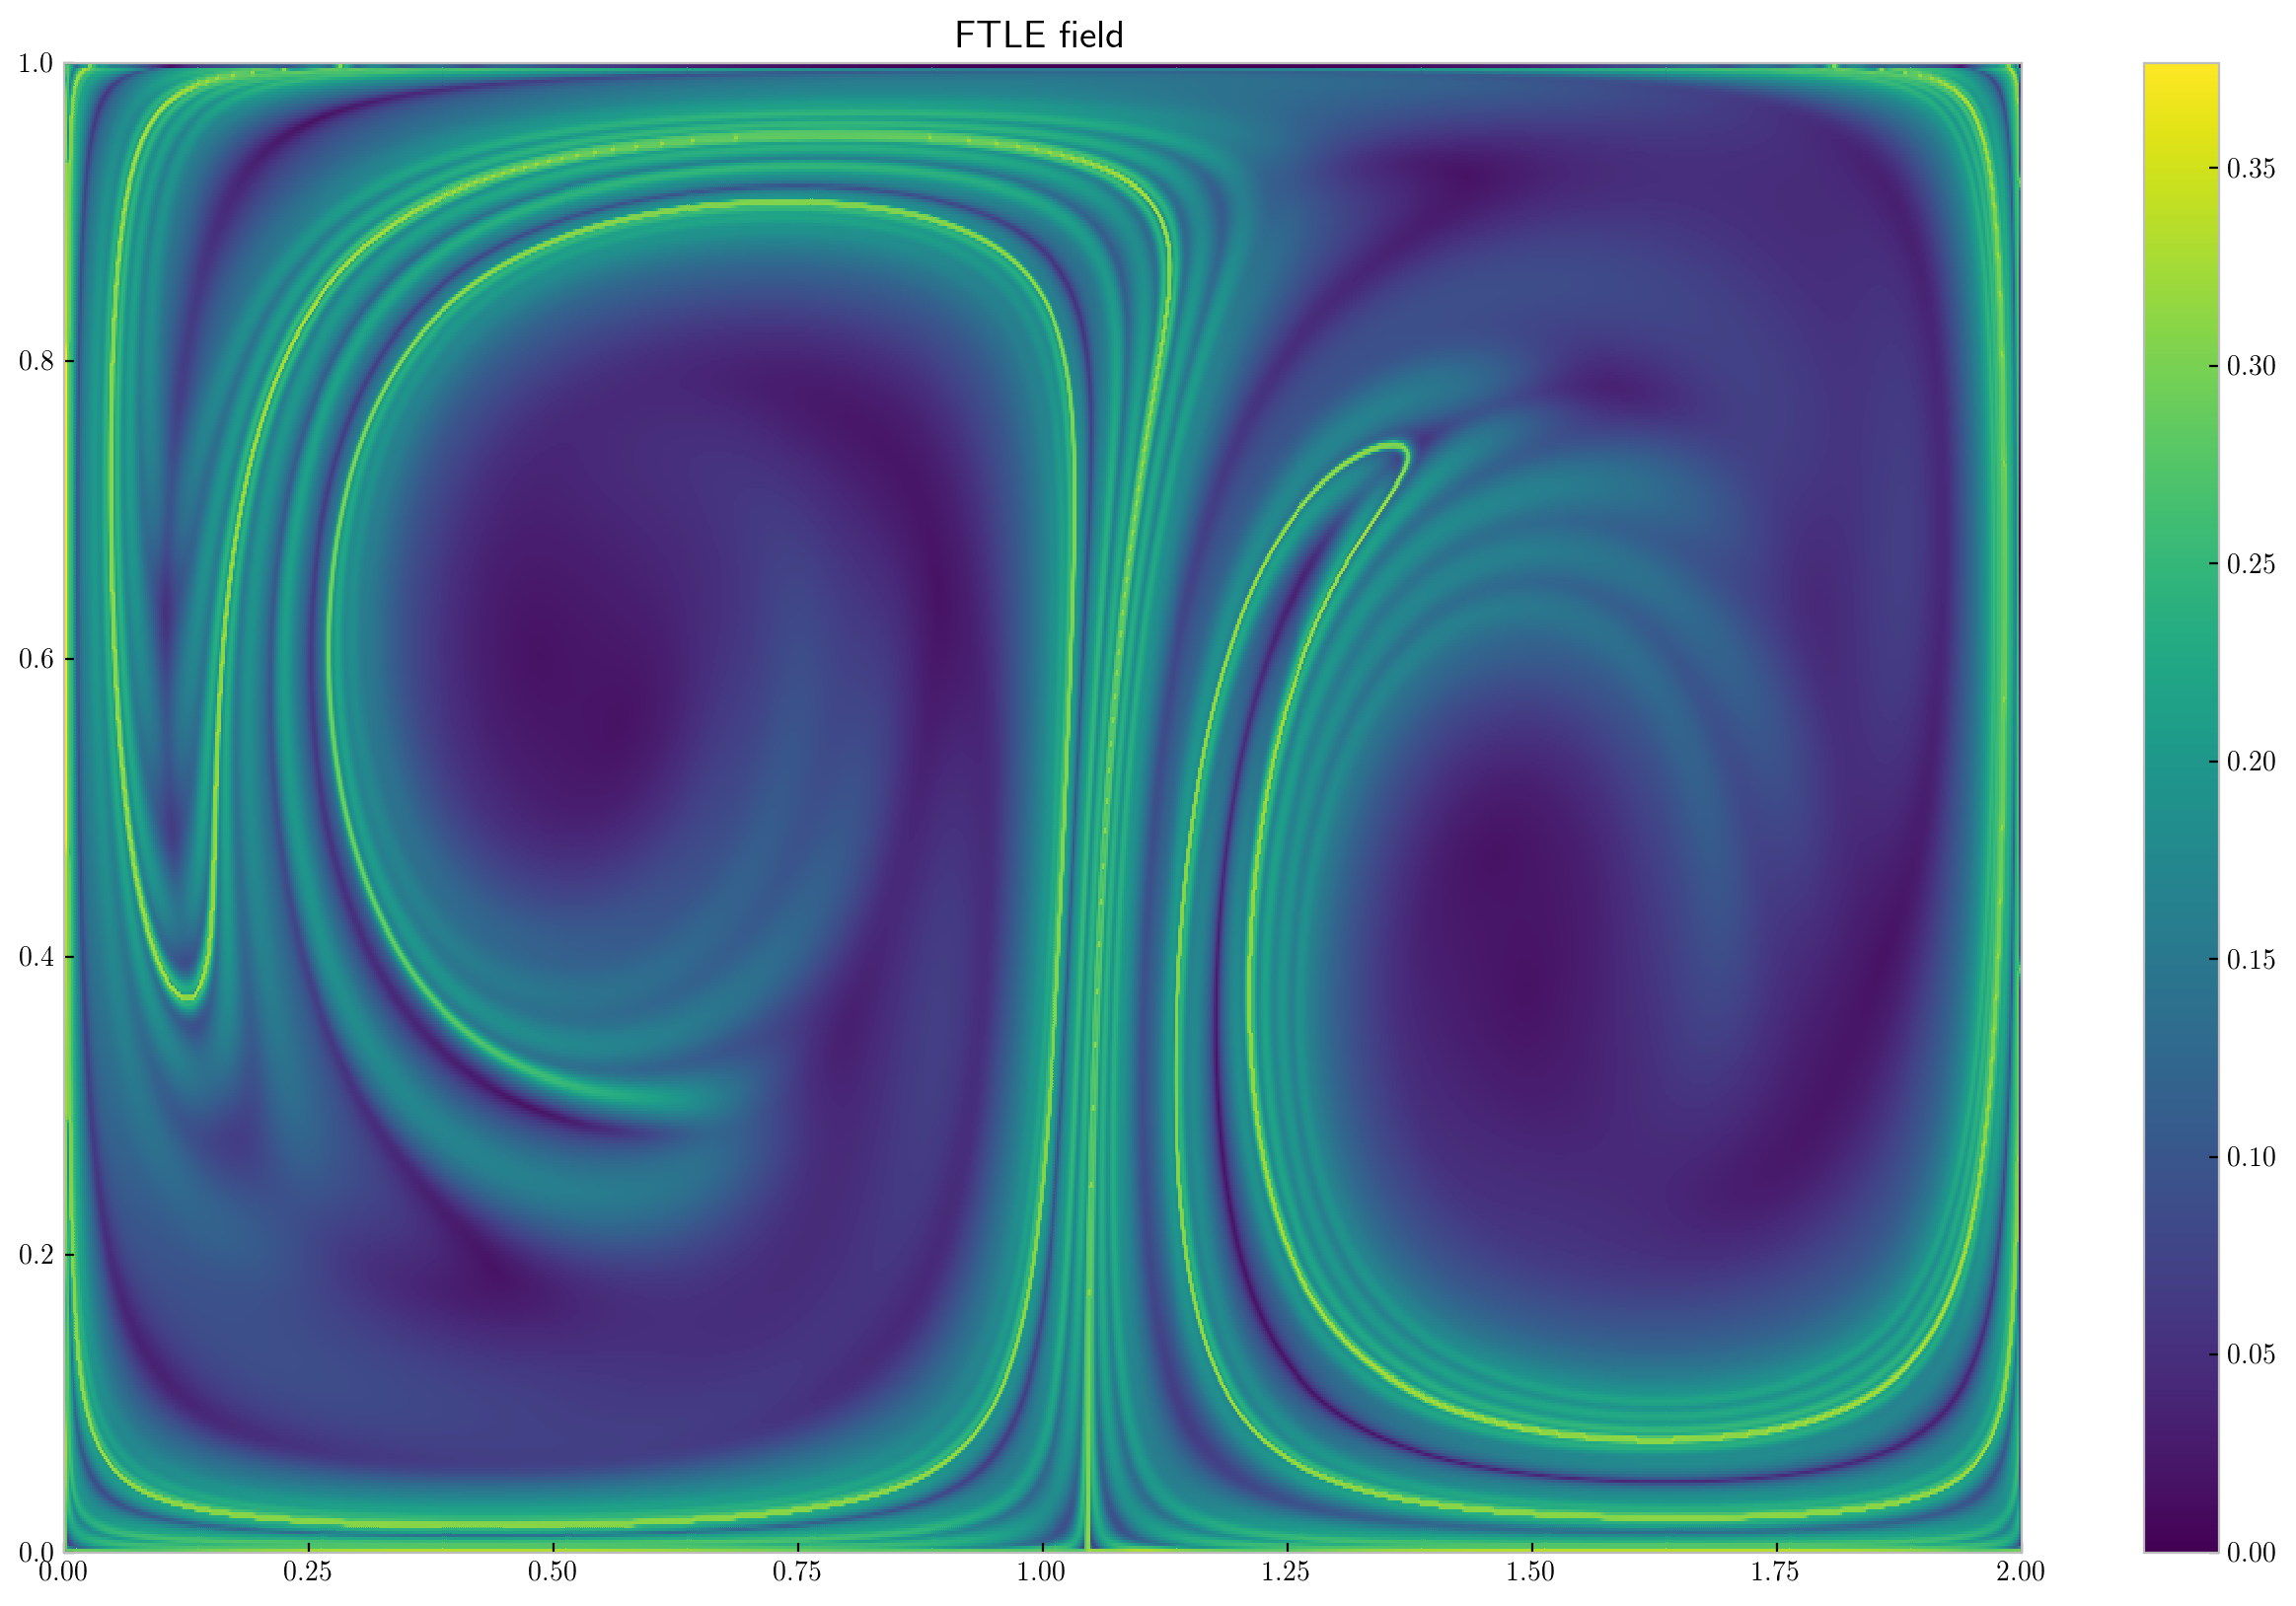

In [10]:
plt.figure(figsize = (16, 10), dpi = 200)
mesh = plt.pcolormesh(pos_init[0,:,:], pos_init[1,:,:], np.log(evals[0,:,:] + 1) / (2*np.abs(t_max - t_min)))
plt.colorbar(mesh)
plt.title(r'FTLE field')
plt.xlim(0,2)
plt.ylim(0,1)

# Step 5: Identify initial points belonging to $\mathcal{G}_{0}$

## i.e., the points for which conditions A and B hold:

### A: $\lambda_{1}(\mathbf{x}_{0}) \neq \lambda_{2}(\mathbf{x}_{0}) > 1 $
### B: $\langle \mathbf{\xi}_{2}(\mathbf{x}_{0}), \nabla^{2} \lambda_2(\mathbf{x}_0) \mathbf{\xi}_2(\mathbf{x}_0) \rangle \leq 0$

In [11]:
A_true = np.logical_and(np.not_equal(evals[0,:,:], evals[1,:,:]), np.greater(evals[0,:,:], 1))

In [12]:
# Find laplacian of largest eigenvector:
d2V = np.empty((Nx, Ny))

# Second derivative, x-direction:
d2V[0,:] = (2*evals[0,0,:] - 5*evals[0,1,:] + 4*evals[0,2,:] - evals[0,3,:])/(dx**2)      # Second order accurate forward difference
d2V[1:-2,:] = (evals[0,2:-1,:] - 2*evals[0,1:-2,:] + evals[0,0:-3,:])/(dx**2)             # Centered difference
d2V[-1,:] = (2*evals[0,-1,:] - 5*evals[0,-2,:] + 4*evals[0,-3,:] - evals[0,-4,:])/(dx**2) # Second order accurate backward difference

# Adding second derivative, y-direction:
d2V[:,0] += (2*evals[0,:,0] - 5*evals[0,:,1] + 4*evals[0,:,2] - evals[0,:,3])/(dy**2)     # Second order accurate forward difference
d2V[:,1:-2] += (evals[0,:,2:-1] - 2*evals[0,:,1:-2] + evals[0,:,0:-3])/(dy**2)            # Centered difference
d2V[:,-1] += (evals[0,:,-1] - 5*evals[0,:,-2] + 4*evals[0,:,-3] - evals[0,:,-4])/(dy**2)  # Second order accurate backward difference

inner = np.sum(evecs[:,0,:,:] * d2V * evecs[:,0,:,:], axis = 0)
B_true = np.less_equal(inner, 0)

In [13]:
# Find laplacian of product between largest eigenvector and -value:
d2VV = np.empty((2, Nx, Ny))

# Second derivative, x-direction:
d2VV[0,0,:] = (2*evals[0,0,:]*evecs[0,0,0,:] - 5*evals[0,1,:]*evecs[0,0,1,:] + 4*evals[0,2,:]*evecs[0,0,2,:] - evals[0,3,:]*evecs[0,0,3,:])/(dx**2)      # Second order accurate forward difference
d2VV[0,1:-2,:] = (evals[0,2:-1,:]*evecs[0,0,2:-1,:] - 2*evals[0,1:-2,:]*evecs[0,0,1:-2,:] + evals[0,0:-3,:]*evecs[0,0,0:-3,:])/(dx**2)             # Centered difference
d2VV[0,-1,:] = (2*evals[0,-1,:]*evecs[0,0,-1,:] - 5*evals[0,-2,:]*evecs[0,0,-2,:] + 4*evals[0,-3,:]*evecs[0,0,-3,:] - evals[0,-4,:]*evecs[0,0,-4,:])/(dx**2) # Second order accurate backward difference

d2VV[1,0,:] = (2*evals[0,0,:]*evecs[1,0,0,:] - 5*evals[0,1,:]*evecs[1,0,1,:] + 4*evals[0,2,:]*evecs[1,0,2,:] - evals[0,3,:]*evecs[1,0,3,:])/(dx**2)      # Second order accurate forward difference
d2VV[1,1:-2,:] = (evals[0,2:-1,:]*evecs[1,0,2:-1,:] - 2*evals[0,1:-2,:]*evecs[1,0,1:-2,:] + evals[0,0:-3,:]*evecs[1,0,0:-3,:])/(dx**2)             # Centered difference
d2VV[1,-1,:] = (2*evals[0,-1,:]*evecs[1,0,-1,:] - 5*evals[0,-2,:]*evecs[1,0,-2,:] + 4*evals[0,-3,:]*evecs[1,0,-3,:] - evals[0,-4,:]*evecs[1,0,-4,:])/(dx**2) # Second order accurate backward difference

# Adding second derivative, y-direction:
d2VV[0,:,0] += (2*evals[0,:,0]*evecs[0,0,:,0] - 5*evals[0,:,1]*evecs[0,0,:,1] + 4*evals[0,:,2]*evecs[0,0,:,2] - evals[0,:,3]*evecs[0,0,:,3])/(dy**2)     # Second order accurate forward difference
d2VV[0,:,1:-2] += (evals[0,:,2:-1]*evecs[0,0,:,2:-1] - 2*evals[0,:,1:-2]*evecs[0,0,:,1:-2] + evals[0,:,0:-3]*evecs[0,0,:,0:-3])/(dy**2)            # Centered difference
d2VV[0,:,-1] += (evals[0,:,-1]*evecs[0,0,:,-1] - 5*evals[0,:,-2]*evecs[0,0,:,-2] + 4*evals[0,:,-3]*evecs[0,0,:,-3] - evals[0,:,-4]*evecs[0,0,:,-4])/(dy**2)  # Second order accurate backward difference

d2VV[1,:,0] += (2*evals[0,:,0]*evecs[1, 0,:,0] - 5*evals[0,:,1]*evecs[1,0,:,1] + 4*evals[0,:,2]*evecs[1,0,:,2] - evals[0,:,3]*evecs[1,0,:,3])/(dy**2)     # Second order accurate forward difference
d2VV[1,:,1:-2] += (evals[0,:,2:-1]*evecs[1,0,:,2:-1] - 2*evals[0,:,1:-2]*evecs[1,0,:,1:-2] + evals[0,:,0:-3]*evecs[1,0,:,0:-3])/(dy**2)            # Centered difference
d2VV[1,:,-1] += (evals[0,:,-1]*evecs[1,0,:,-1] - 5*evals[0,:,-2]*evecs[1,0,:,-2] + 4*evals[0,:,-3]*evecs[1,0,:,-3] - evals[0,:,-4]*evecs[1,0,:,-4])/(dy**2)  # Second order accurate backward difference

inner2 = np.sum(evecs[:,0,:,:] * d2VV, axis = 0)

B_true2 = np.less_equal(inner2, 0)

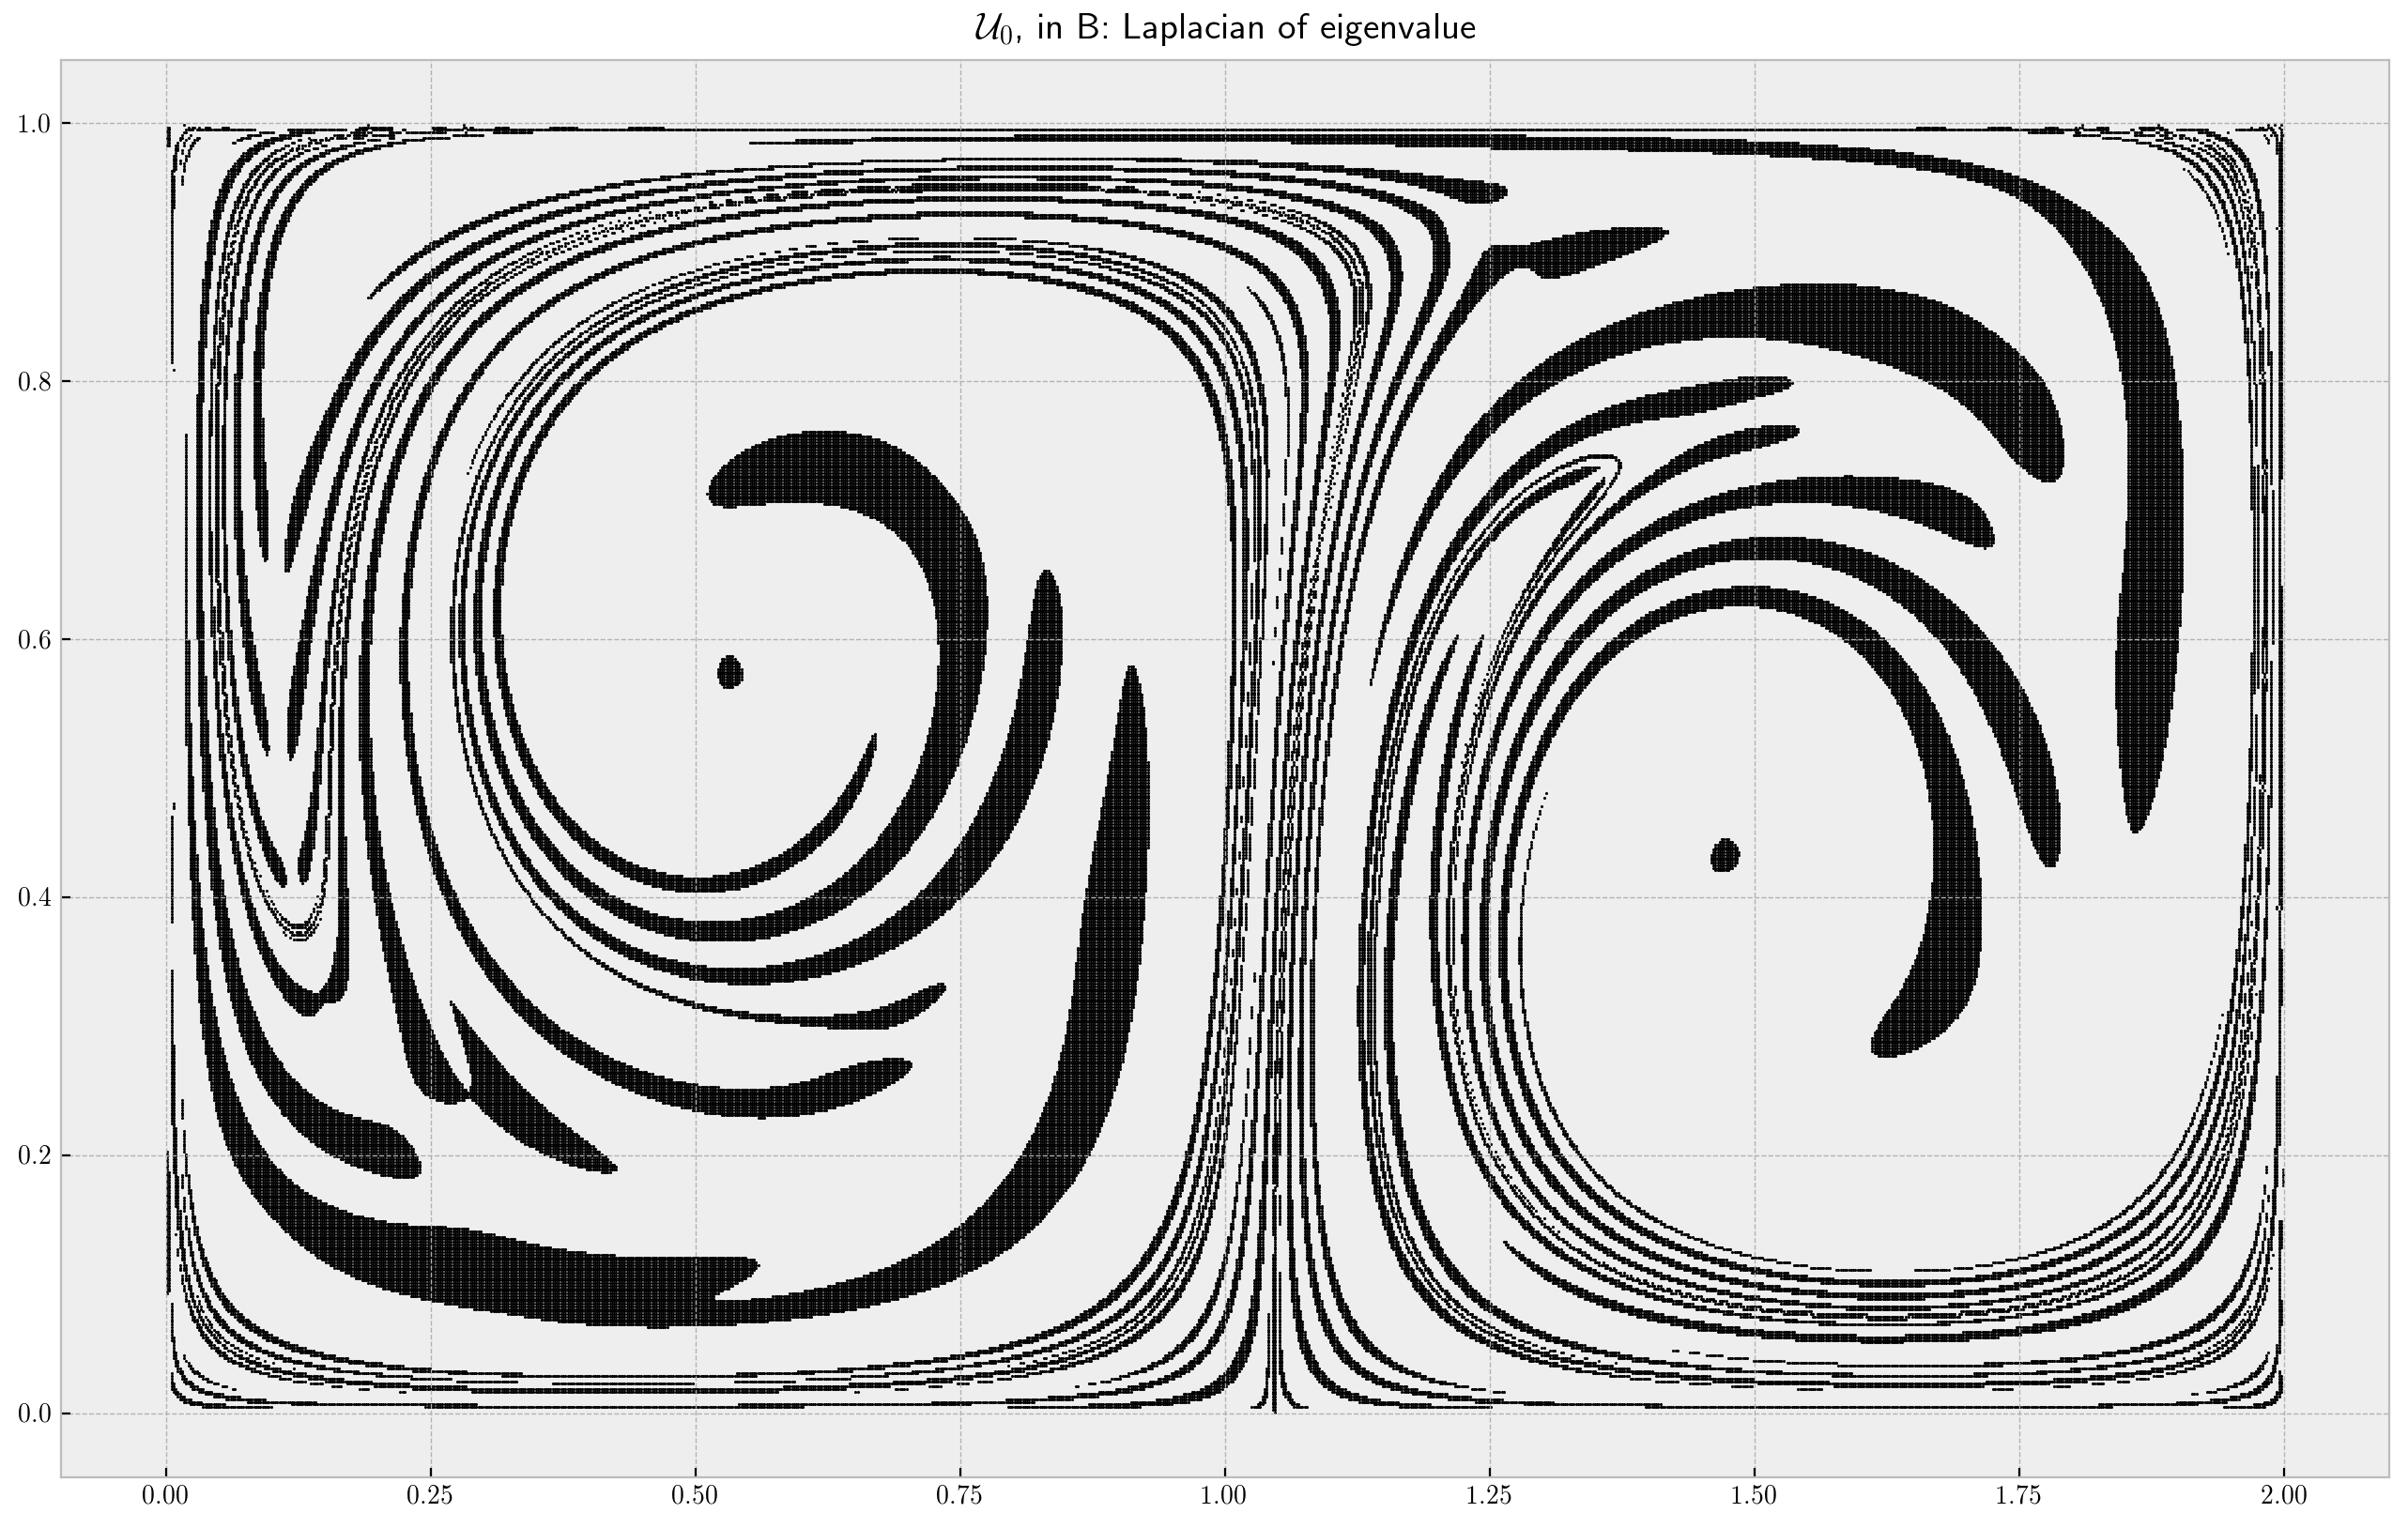

In [14]:
plt.figure(figsize = (16,10), dpi = 200)
plt.scatter(pos_init[0,np.logical_and(A_true,B_true)], pos_init[1,np.logical_and(A_true,B_true)], lw = 0, marker = '.', s = 5, color = 'k')
plt.title(r'$\mathcal{U}_{0}$, in B: Laplacian of eigenvalue')

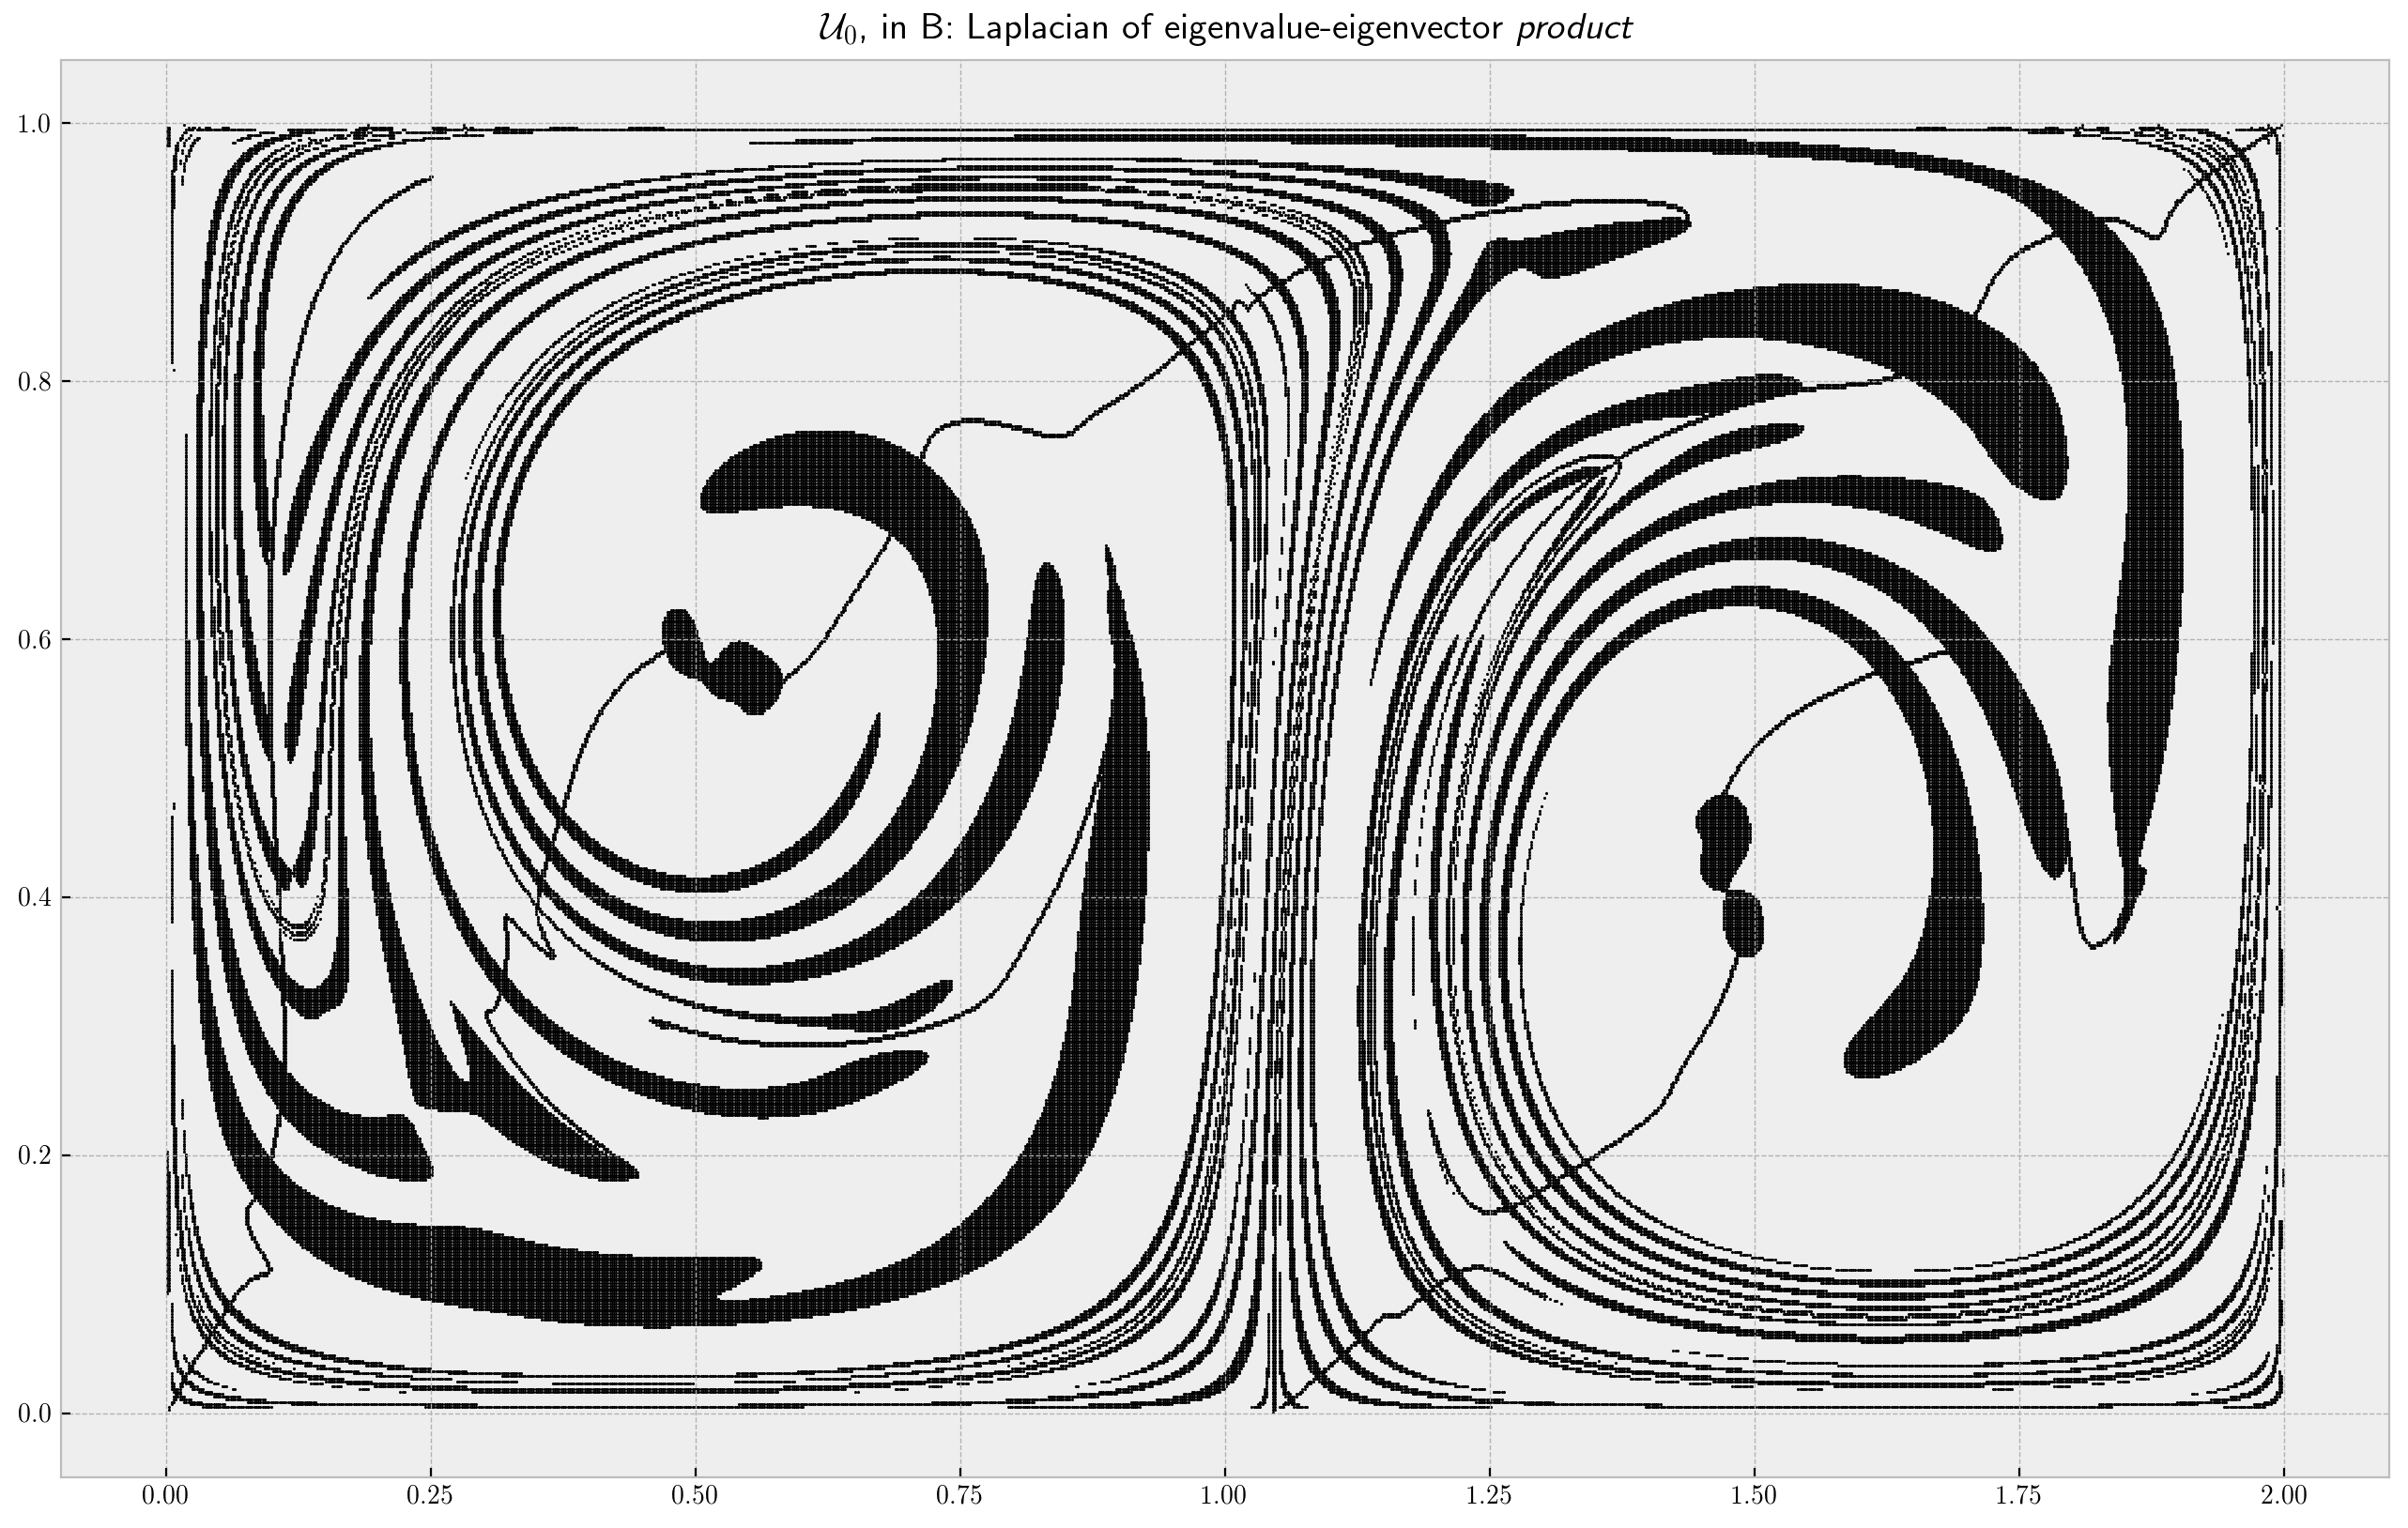

In [15]:
plt.figure(figsize = (16,10), dpi = 200)
plt.scatter(pos_init[0,np.logical_and(A_true,B_true2)], pos_init[1,np.logical_and(A_true,B_true2)], lw = 0, marker = '.', s = 5, color = 'k')
plt.title(r'$\mathcal{U}_{0}$, in B: Laplacian of eigenvalue-eigenvector \emph{product}')

# Step 6: Choose subset $\mathcal{G}_{0}$, as the intersection of $\mathcal{U}_{0}$ and four vertical and horizontal lines

In [65]:
mask = np.zeros((Nx, Ny), dtype = np.bool)

for i in range(1,5):
    mask[:, np.minimum(int(i*Ny/5), Ny - 1)] = True
    mask[np.minimum(int(i*Nx/5), Nx - 1), :] = True
    
one_mask_to_rule_them_all = np.logical_and(mask, np.logical_and(A_true, B_true))    

G_0 = pos_init[:, one_mask_to_rule_them_all]

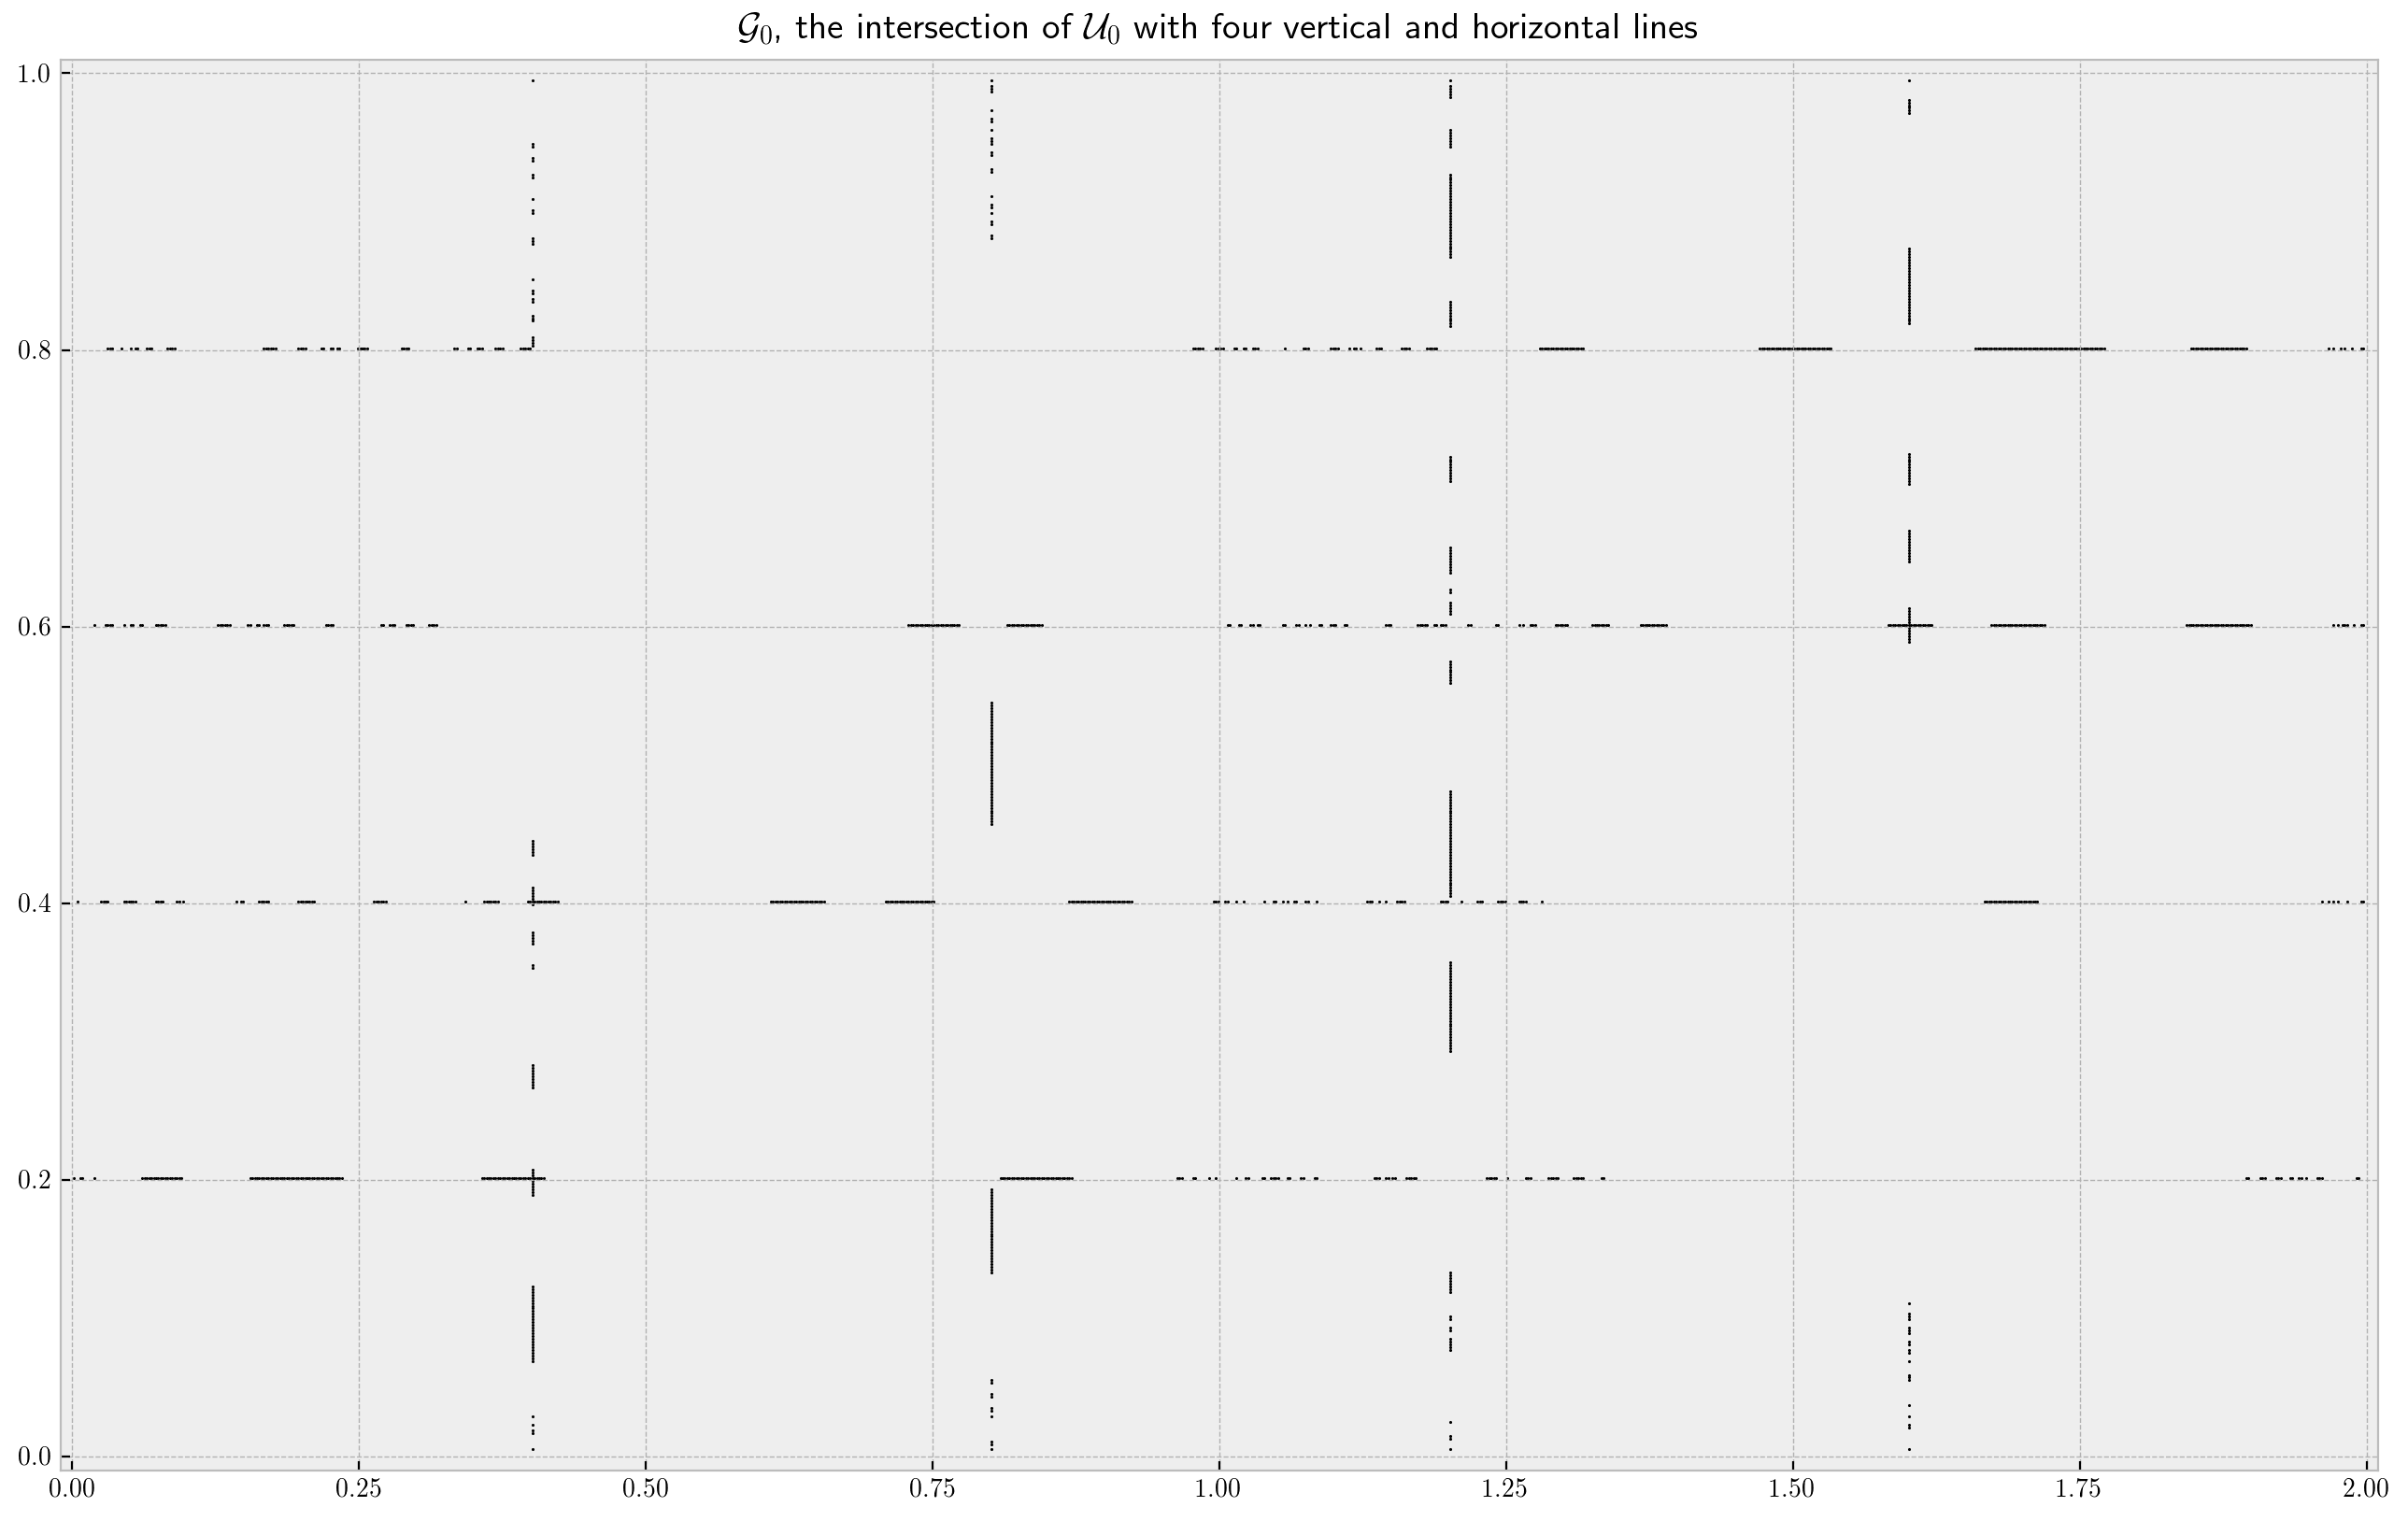

In [66]:
plt.figure(figsize = (16,10), dpi = 200)
plt.scatter(G_0[0], G_0[1], marker = '.', c = 'k', lw = 0, s = 5)
plt.xlim([-0.01, 2.01])
plt.ylim([-0.01, 1.01])
plt.title(r'$\mathcal{G}_{0}$, the intersection of $\mathcal{U}_{0}$ with four vertical and horizontal lines')

# Step 7: Define rescaled vector field from $\xi_{1}$ and advect the points in $\mathcal{G}_{0}$

## Using cubic splines:

In [18]:
smallest_eval_spline = RectBivariateSpline(pos_init[1,0,:], pos_init[0,:,0], evals[1,:,:].T)
largest_eval_spline  = RectBivariateSpline(pos_init[1,0,:], pos_init[0,:,0], evals[0,:,:].T)

smallest_evect_x_spline = RectBivariateSpline(pos_init[1,0,:], pos_init[0,:,0], evecs[0,1,:,:].T)
smallest_evect_y_spline = RectBivariateSpline(pos_init[1,0,:], pos_init[0,:,0], evecs[1,1,:,:].T)


In [19]:
class Rescaled():
    def __init__(self, smallest_eval_spline, largest_eval_spline, smallest_evect_x_spline, smallest_evect_y_spline):
        self.smallest_eval_spline = smallest_eval_spline
        self.largest_eval_spline = largest_eval_spline
        self.smallest_evect_x_spline = smallest_evect_x_spline
        self.smallest_evect_y_spline = smallest_evect_y_spline
        self.f_old = None
        
    def __call__(self, t, x):
        lambda1 = self.smallest_eval_spline.ev(x[1], x[0])
        lambda2 = self.largest_eval_spline.ev(x[1], x[0])
        alpha = ((lambda2 - lambda1)/(lambda2 + lambda1))**2
        evec_x = self.smallest_evect_x_spline.ev(x[1], x[0])
        evec_y = self.smallest_evect_y_spline.ev(x[1], x[0])
        length = np.sqrt(evec_x**2 + evec_y**2)
        
        evec_x /= length
        evec_y /= length
        
        if self.f_old is None:
            sign = 1
        else:
            sign = np.sign(np.sum(self.f_old * alpha * np.array([evec_x, evec_y])))
            

        return np.array([sign*alpha*evec_x/length, sign*alpha*evec_y/length])

In [246]:
T = 10.
t = 0.
h = 0.1

foo = Rescaled(smallest_eval_spline, largest_eval_spline, smallest_evect_x_spline, smallest_evect_y_spline)

ts = np.ones(np.shape(G)[1]) * t
hs = np.ones(np.shape(G)[1]) * h

G = np.copy(G_0)

traj = []

integration_mask = np.less(ts, T)

integrator = rk4

for i in range(10):
#while np.any(integration_mask):
    traj.append(G)
    foo.f_old = foo(ts[integration_mask], G[:,integration_mask])
    hs[integration_mask] = np.minimum(hs[integration_mask], T - ts[integration_mask])
    ts[integration_mask], G[:, integration_mask], hs[integration_mask] = integrator(ts[integration_mask], G[:, integration_mask], hs[integration_mask], foo)
    #G[:, integration_mask] = tmp
    integration_mask = np.less(ts, T)
    #traj.append(G)
    #print(np.sum(integration_mask))

In [248]:
k1 = foo(ts, G)
k2 = foo(ts + hs/2, G + hs/2 * k1)
k3 = foo(ts + hs/2, G + hs/2 * k2)
k4 = foo(ts + hs, G + hs * k3)

#print(k1)
#print(k2)
#print(k3)
#print(k4)

print(G)
print(G + hs/6 * (k1 + 2*k2 + 2*k3 + k4))

[[-0.30923648 -0.18231542 -0.12730854 ...,  1.87945526  1.97767547
   1.89071999]
 [ 0.2112672   0.1838478  -0.0848883  ...,  0.0628247   0.20356575
   0.04612111]]
[[-0.30975434 -0.18291302 -0.04193802 ...,  1.95973234  1.98706953
   1.96735924]
 [ 0.31124232  0.28369607 -0.12758068 ...,  0.11644116  0.30296935
   0.09769535]]


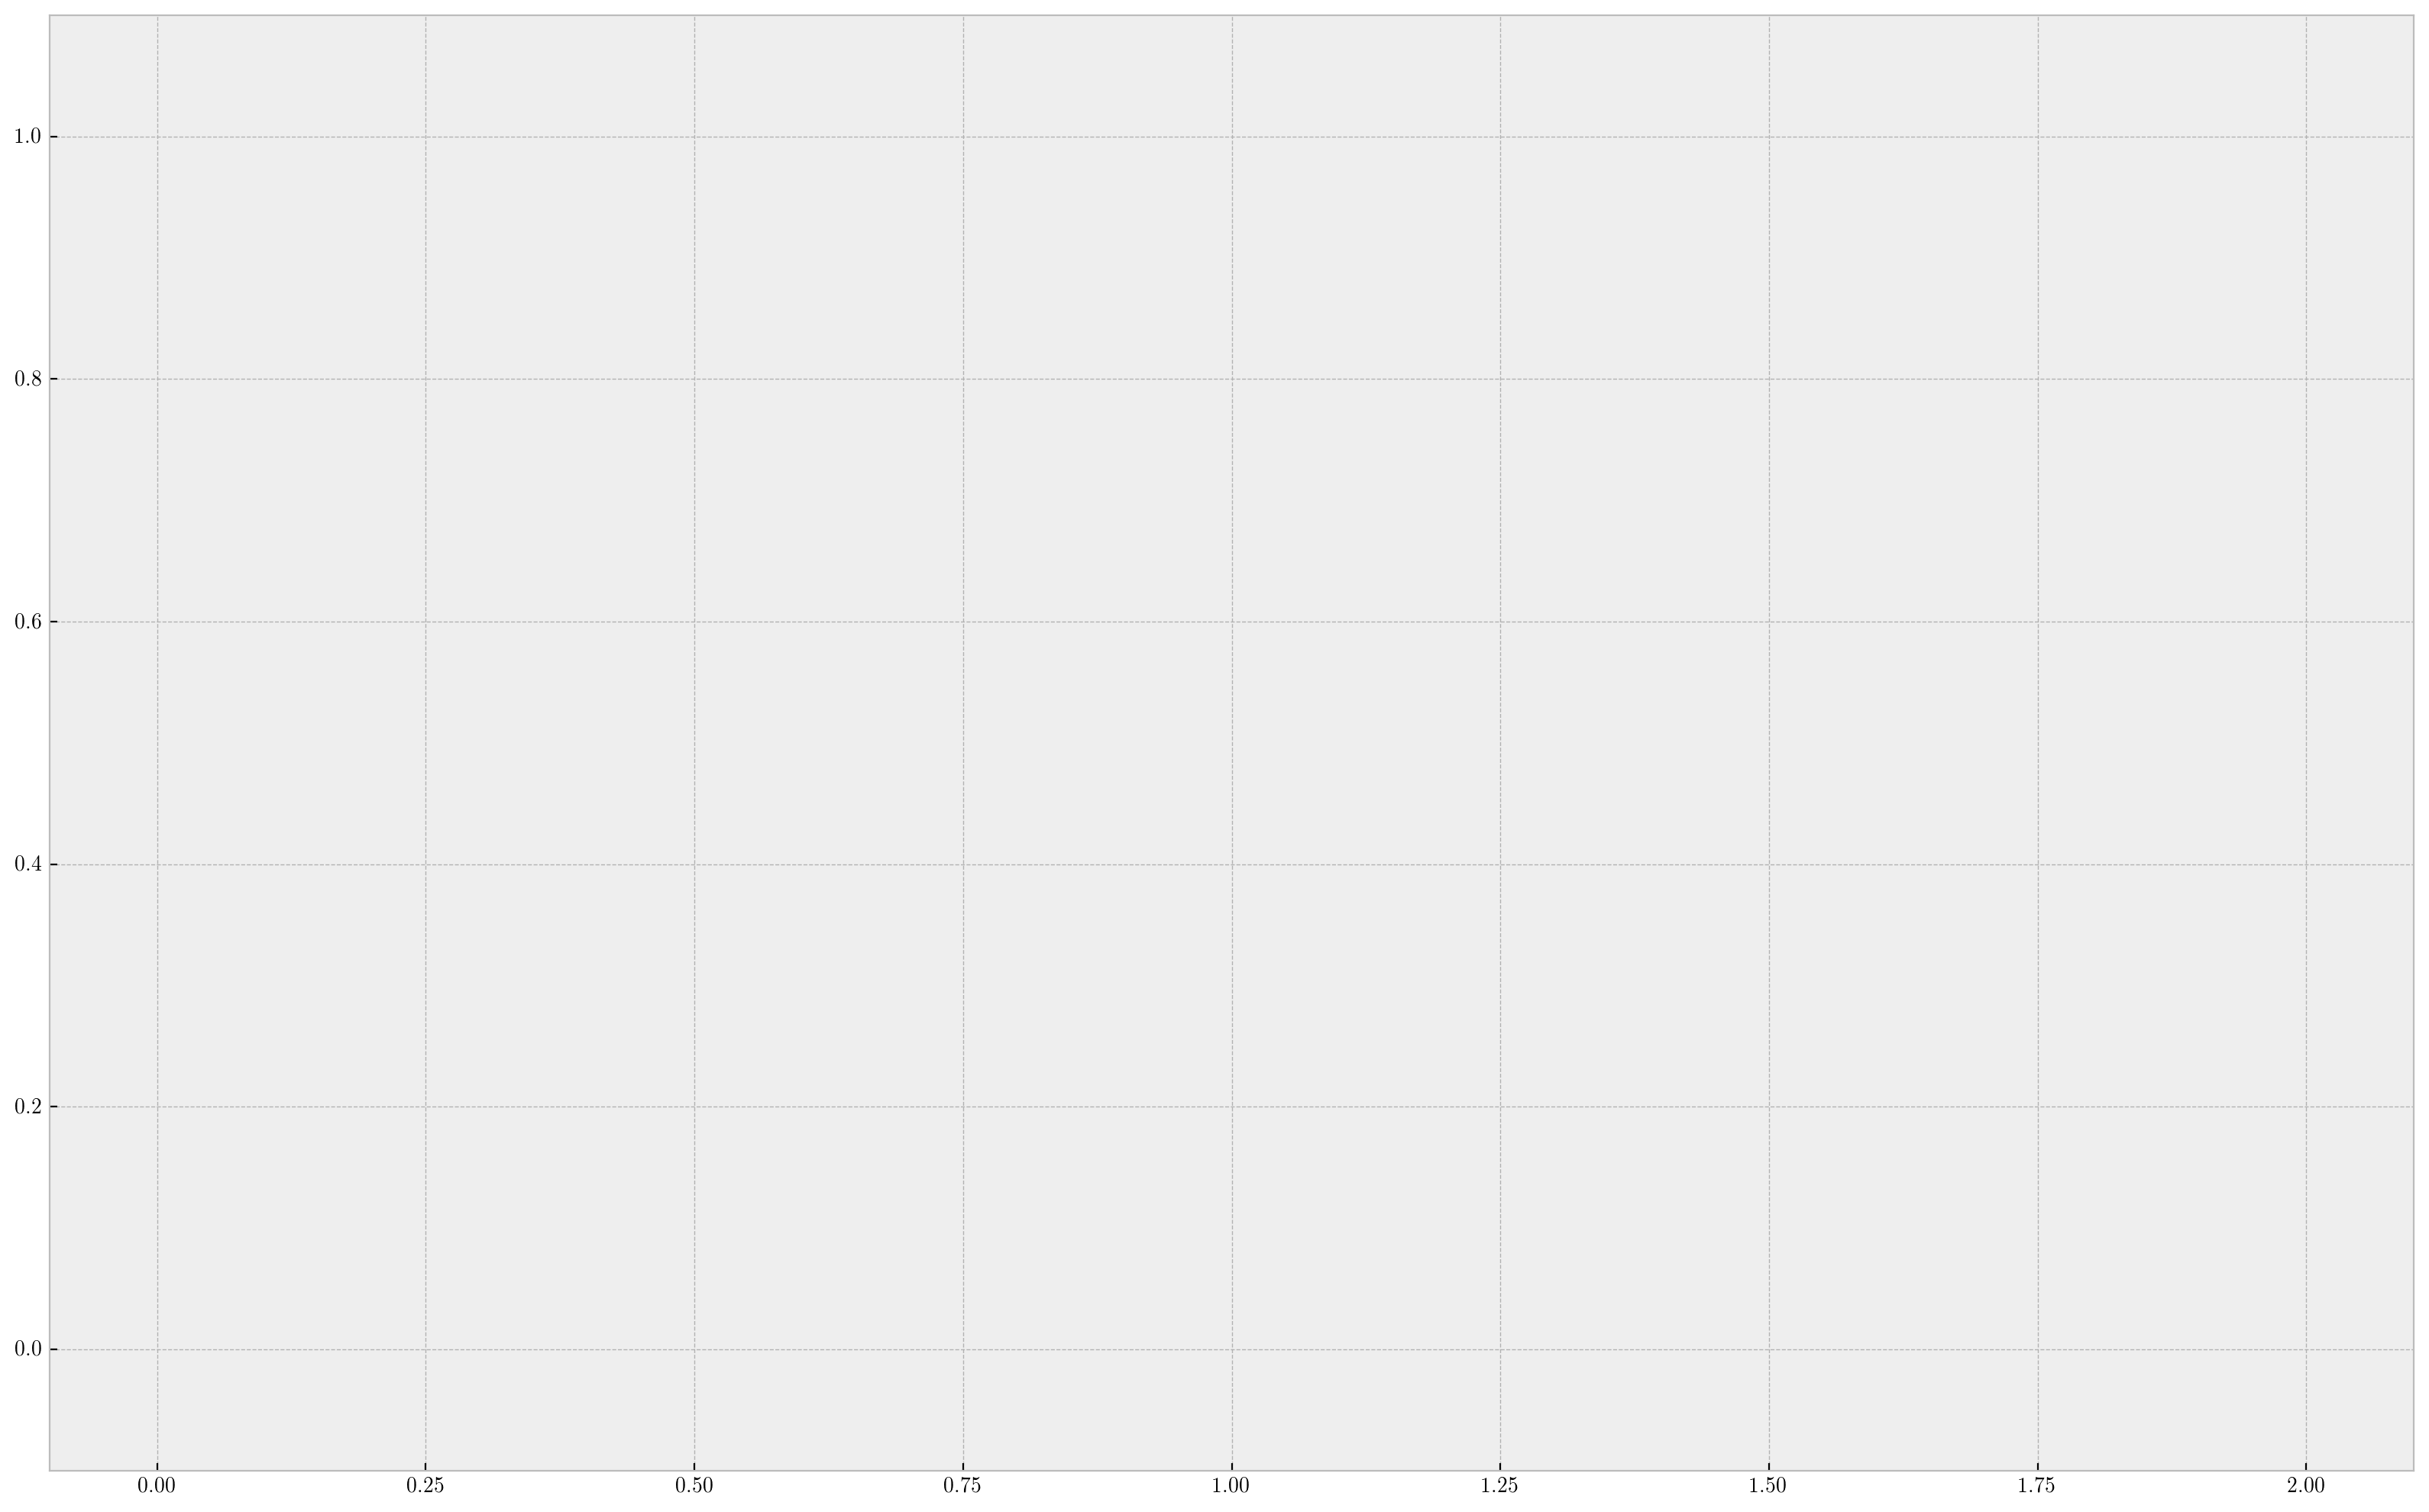

In [226]:
plt.figure(figsize = (16,10), dpi = 200)
t2 = np.asarray(traj)
for j in range(np.shape(t2)[2]):
    plt.plot(t2[:,0,j], t2[:,1,j], c = 'k', lw = 1, alpha = 0.5)

plt.xlim([-0.1, 2.1])
plt.ylim([-0.1, 1.1])

plt.tight_layout()

## Using special-purpose linear interpolation:

In [60]:
class LinearSpecial():
    def __init__(self, xc, yc, xi):
        self.xc = xc
        self.yc = yc
        self.dx = xc[-1]- xc[-2]
        self.dy = yc[-1] - yc[-2]
        self.xi = xi
        self.Nx = np.size(xc)
        self.Ny = np.size(yc)
        self.fold = None
        #print(np.shape(xi))
        #print(np.shape(self.xi))
        
    def __call__(self, t, x):
        # Calculate indices for lower left corner in cell:
        i = int(x[0]/self.dx)
        j = int(x[1]/self.dy)
        
        # If outside the domain, move inside:
        i = np.minimum(i, Nx - 2)
        j = np.minimum(j, Ny - 2)
        
        # Use the lower left corner as reference, calculate 
        # the rotation of the other vectors, and rotate by
        # 180 degrees if necessary (due to oriental 
        # discontinuity)
        subxi = np.zeros((2, 2, 2))
        subxi[:] = self.xi[:, i:i+2, j:j+2]
        
        #print(np.shape(self.xi[:, i:i+2, j:j+2]))
        
        for n in range(2):
            for m in range(2):
                if np.logical_and(np.equal(n,m), np.equal(n,0)):
                    pass
                else:
                    # Flip direction if dot product is negative
                    subxi[:,n,m] = np.sign(np.dot(subxi[:,0,0], subxi[:,n,m])) * subxi[:,n,m]
                    
        # Linear interpolarion:
        W = np.zeros((1,2,2))
        W[0,0,0] = self.xc[i+1] - x[0]
        W[0,0,1] = 1 - W[0,0,0]
        W[0,1,0] = self.yc[j+1] - x[1]
        W[0,1,1] = 1 - W[0,1,0]
        
        V = np.sum(W * subxi, axis = (1,2))
        
        V /= np.sqrt(V[0]**2 + V[1]**2)
        
        # Check orientation against previous vector:
        if self.fold is None:
            return V
        else:
            # If dot product is negative, flip sign:
            return np.sign(np.dot(self.fold, V)) * V

In [67]:
bar = LinearSpecial(pos_init[0,:,0], pos_init[1,0,:], evecs[:,1,:,:])

# Loop over all initial conditions
# If (A and B), check if point 
# corresponds to a local max.
# of lambda_2 (largest eigval)

r = 0.01

LCSs = []

#progressbar = FloatProgress(min = 0, max = Nx)
#display(progressbar)

for i in range(Nx):
    #progressbar.value = i
    for j in range(Ny):
        if one_mask_to_rule_them_all[i,j]:
            
            # Re-initialize the derivative function:
            bar.fold = None
            
            dists = np.sum((pos_init[:,i,j].reshape(2,1,1) - pos_init)**2, axis = 0)
            if np.less(evals[0,i,j], np.amax(evals[1,:,:][np.less(dists, r)])):
                pass
            else:
                T = 2
                t = 0
                h = 0.005
                Nt = int((T-t)/h)
                
                xs = np.zeros((2, Nt))
                xs[:,0] = pos_init[:, i, j]
                
                for n in range(1, Nt):
                    bar.fold = bar(t, xs[:, n-1])
                    t, tmp, h = rk4(t, xs[:, n-1], h, bar)
                    xs[:, n] = tmp
                    if np.logical_or(np.logical_or(np.less(xs[0,n], 0.), np.greater(xs[0,n], 2.)), np.logical_or(np.less(xs[1,n], 0.), np.greater(xs[1,n], 1.))):
                        break
                
                LCSs.append(xs[:,:n])
                print(len(LCSs))
                print(i*Nx + j)

1
100
2
2200
3
3100
4
4100
5
22300
6
25300
7
25400
8
26300
9
29300
10
45200
11
46200
12
48200
13
71200
14
73200
15
74200
16
77100
17
78100
18
79100
19
80100
20
80300
21
81100
22
81300
23
82100
24
83100
25
84100
26
85100
27
86100
28
87100
29
88100
30
89100
31
90100
32
91100
33
92100
34
93100
35
94100
36
95100
37
96100
38
97100
39
98100
40
99100
41
100100
42
101100
43
102100
44
103100
45
104100
46
105100
47
106100
48
107100
49
108100
50
109100
51
110100
52
111100
53
112100
54
112400
55
113100
56
113400
57
114100
58
115100
59
116100
60
117100
61
131200
62
132200
63
133200
64
134200
65
134300
66
135200
67
135300
68
136200
69
138300
70
139300
71
140300
72
145300
73
146300
74
147300
75
148300
76
155300
77
156300
78
157300
79
158300
80
171200
81
172400
82
173400
83
178100
84
179100
85
179200
86
180100
87
180200
88
181100
89
181200
90
182100
91
182200
92
183100
93
183200
94
184100
95
184200
96
185100
97
185200
98
186100
99
187100
100
188100
101
189100
102
190100
103
191100
104
192100
105
19310

ValueError: could not broadcast input array from shape (2,2,0) into shape (2,2,2)

In [78]:
np.shape(LCSs[-5])

(2, 399)

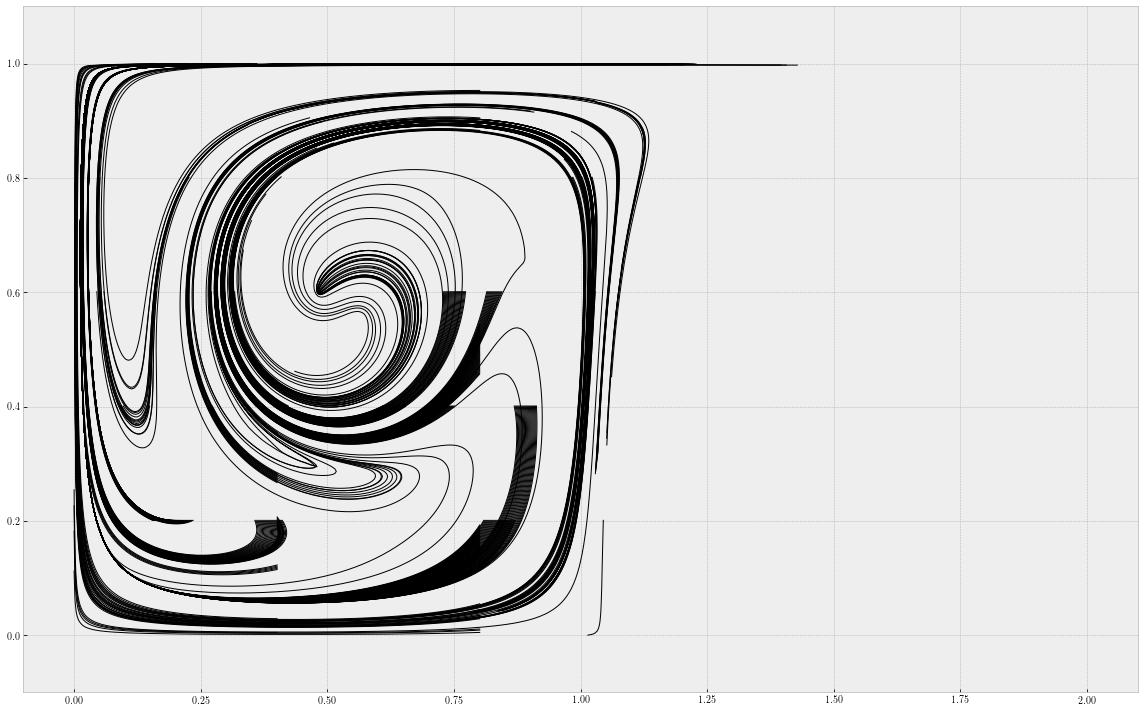

In [80]:
plt.figure(figsize = (16, 10))

for i in range(len(LCSs)):
    plt.plot(LCSs[i][0,:], LCSs[i][1,:], c = 'k', lw = 1)
    
plt.xlim([-0.1, 2.1])
plt.ylim([-0.1, 1.1])

plt.tight_layout()

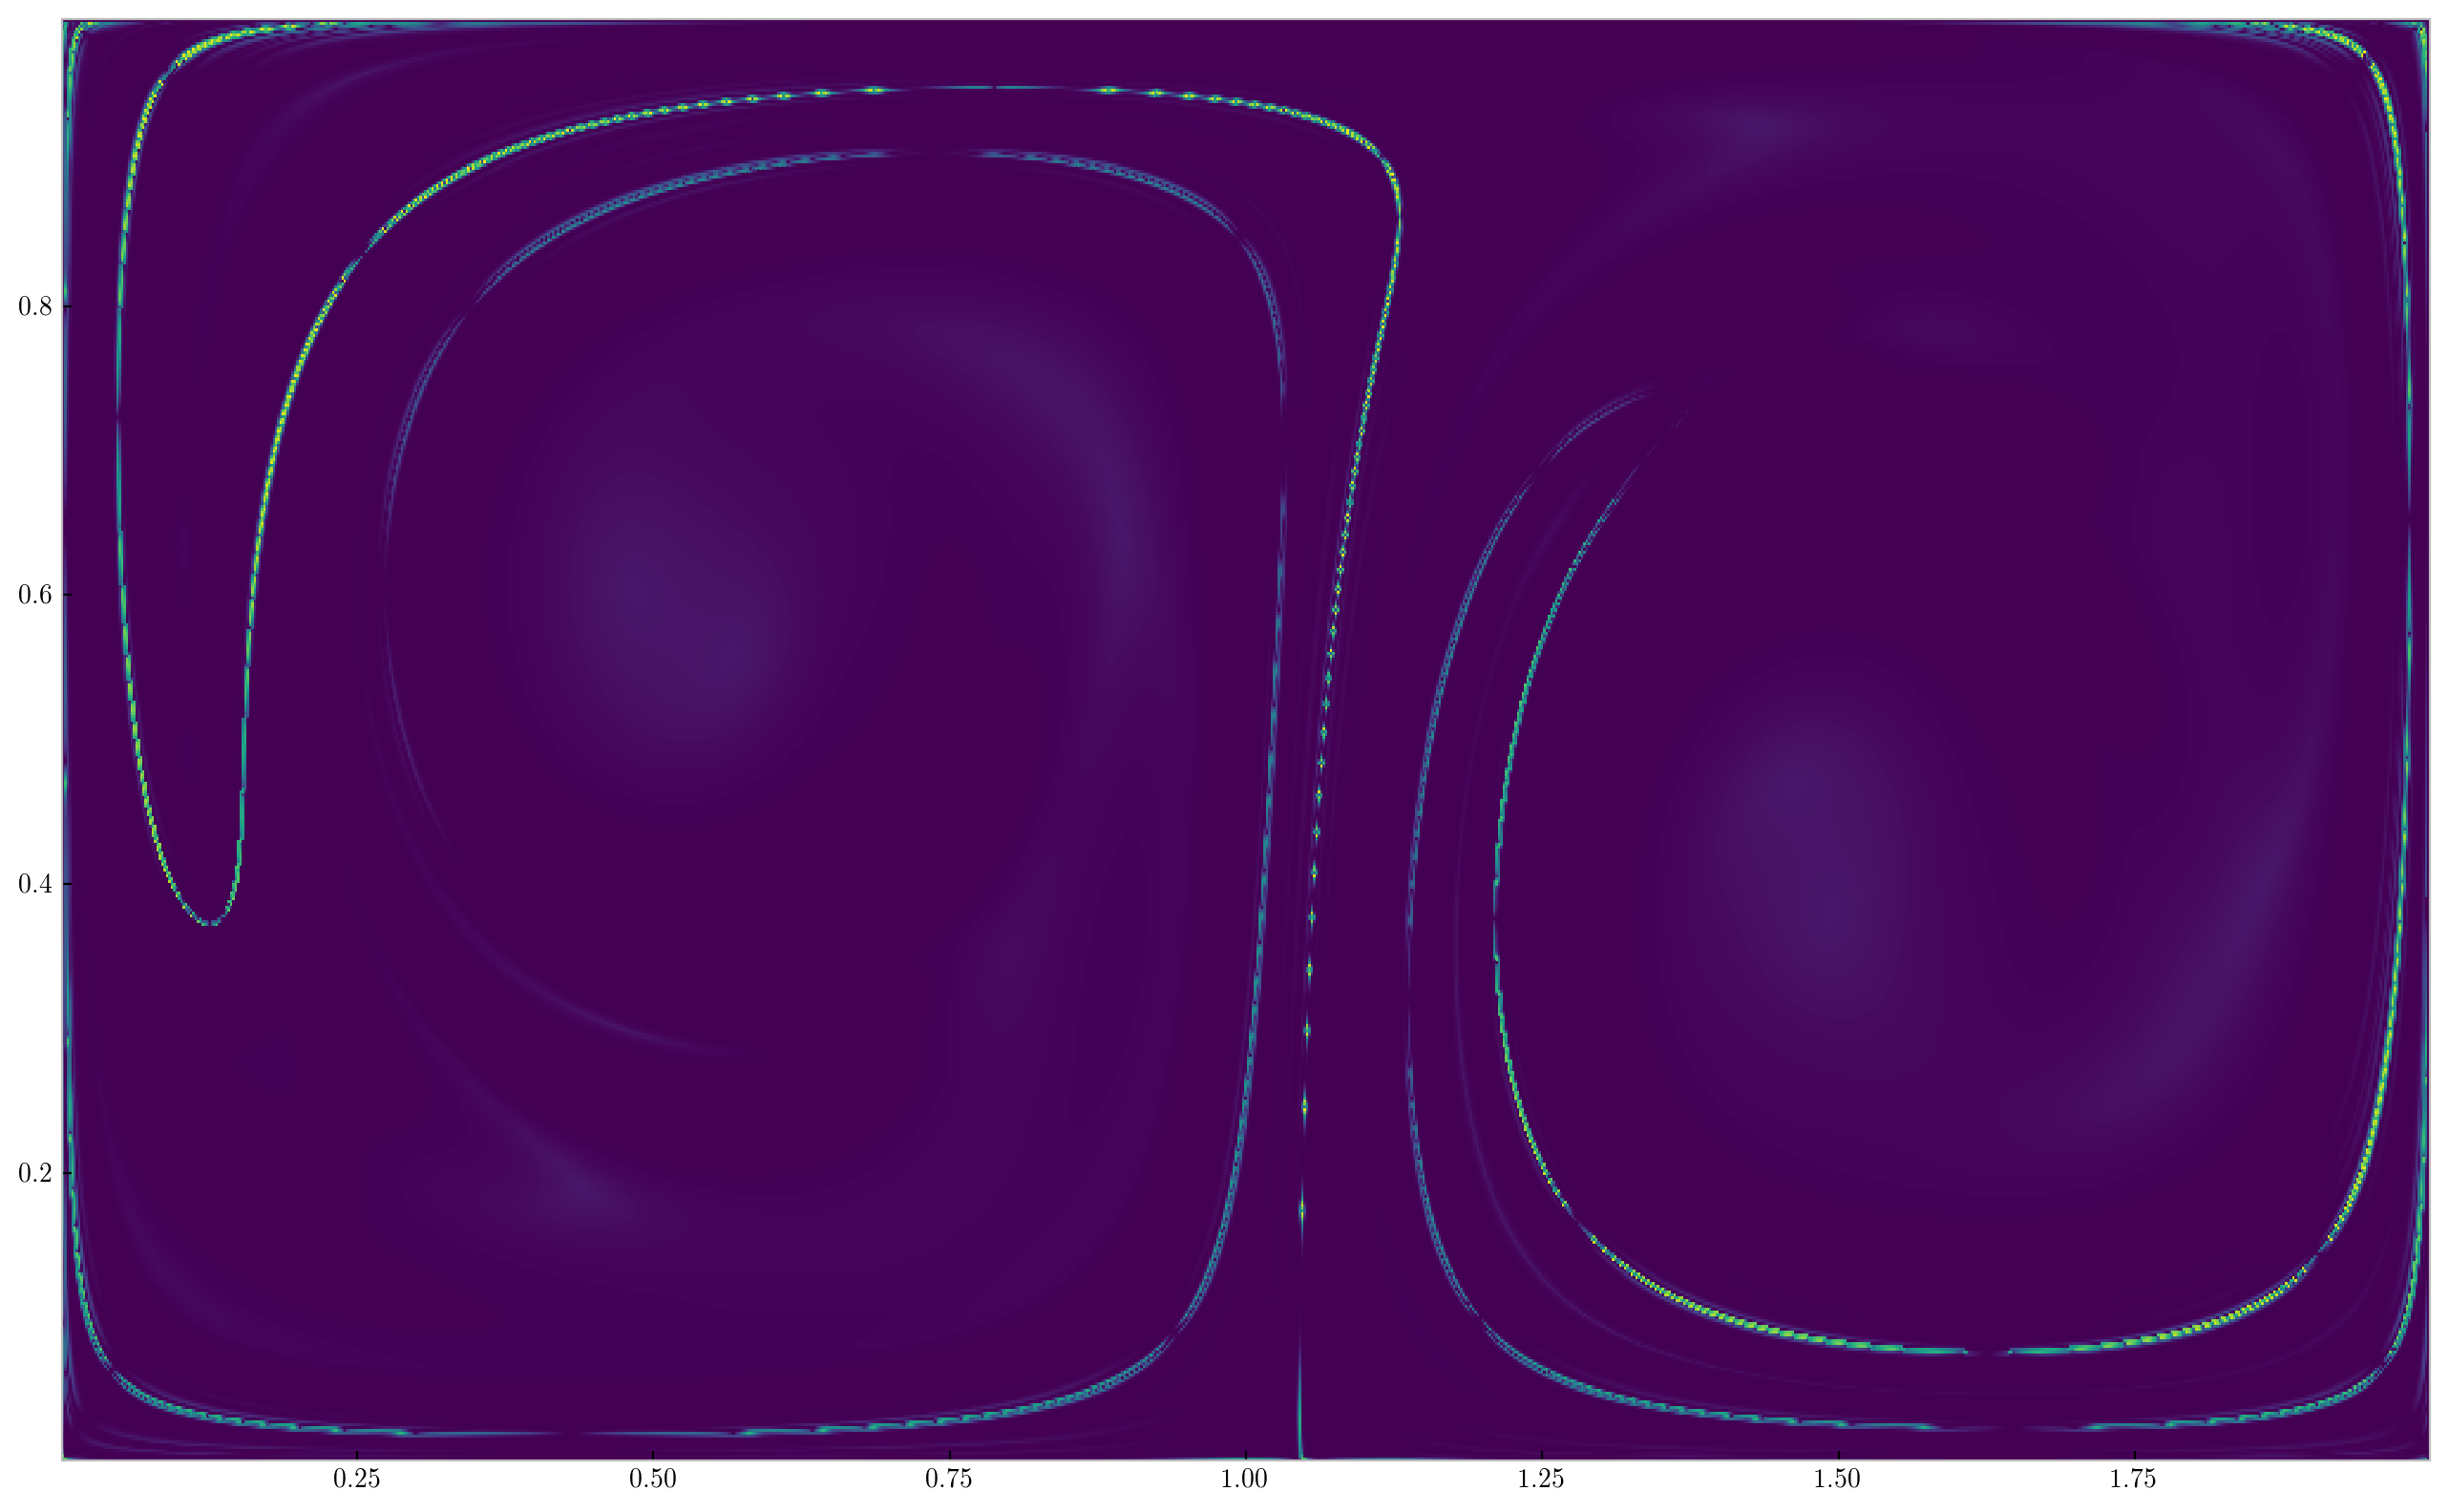

In [134]:
plt.figure(figsize = (16,10), dpi = 200)
plt.pcolormesh(pos_init[0], pos_init[1], np.log(evals[1] + 1))

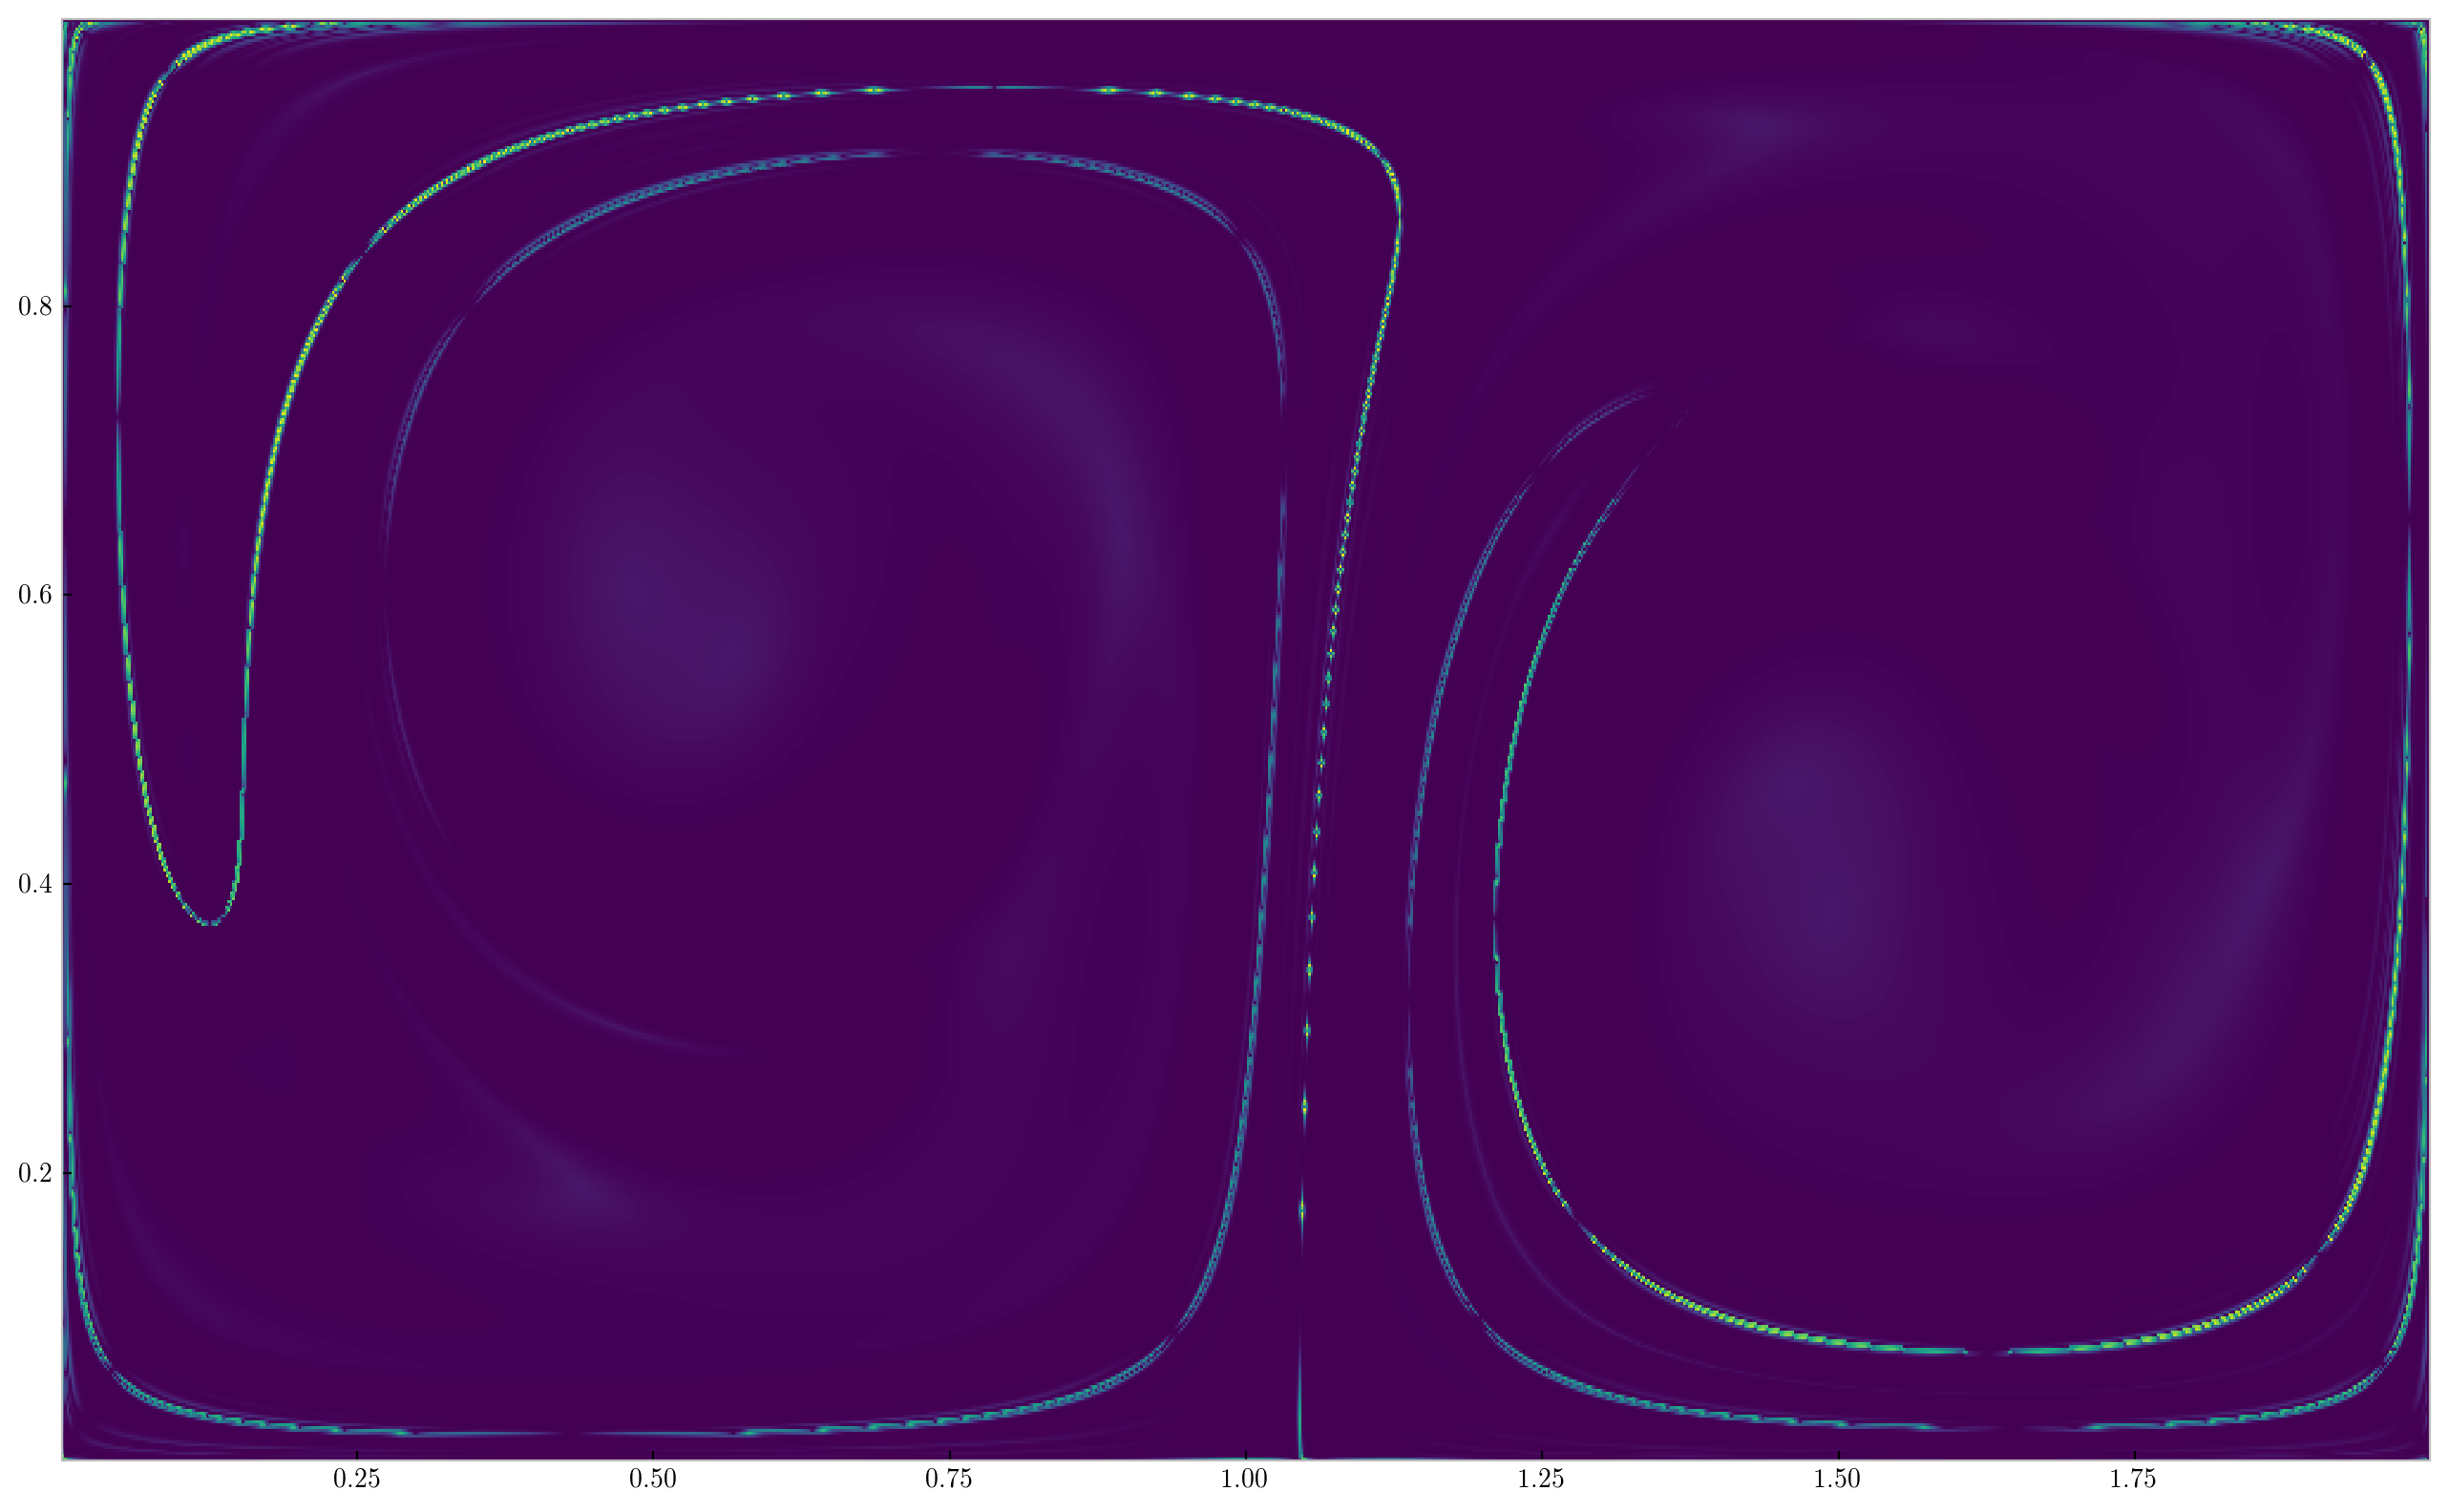

In [133]:
plt.figure(figsize = (16, 10), dpi = 200)
plt.pcolormesh(pos_init[0], pos_init[1], np.log(smallest_eval_spline.ev(pos_init[1], pos_init[0]) + 1) )

In [137]:
np.shape(G_0)

(2, 1357)